# Dataset Description

The dataset contains speech, non-speech features and clinical variables from participants (215 in total) of a depression related study. Participants were asked to perform small verbal tasks (recounting a positive, and negativeevent). Based on speech recordings of these tasks, vocal features have been derived fromdifferent categories. Each feature contains a tag ‘_{pos,neg}’, which refers to the vocal task itwas extracted from. Clinical and demographic variables of participants can be found at thebeginning. Most notably, the study was meant to show a link between voice patterns and adepression scale (variable ‘dep_scale’). The participants can be classified into a group with (dep_scale> 17) and without (dep_scale< 17) depressive symptoms.

# Exploratory Data Analysis (EDA)

The first thing we'll need to do is load in the data-set and the libraries we'll be using.

In [1]:
# import all libraries
print('Installing dependencies...')
!pip install impyute
!pip install xgboost
!pip install pgmpy

print('Importing libraries and defining some helper functions...')
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pgmpy as pg
import xgboost as xgb
from impyute.imputation.cs import mice
from pgmpy.models import BayesianModel

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import Callback

from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from scipy import stats
import pylab as pl

# Hack to allow seaborn and scikit-learn to run without warnings
import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format='retina'
sns.set_style('whitegrid')

print('🎉 Done!')

Installing dependencies...
     |████████████████████████████████| 166.7 MB 52.4 MB/s 
     |████████████████████████████████| 331 kB 25.6 MB/s 
     |████████████████████████████████| 1.6 MB 57.7 MB/s 
     |████████████████████████████████| 9.5 MB 67.9 MB/s 
     |████████████████████████████████| 231 kB 76.0 MB/s 
  Attempting uninstall: decorator
    Found existing installation: decorator 5.0.9
    Not uninstalling decorator at /shared-libs/python3.7/py-core/lib/python3.7/site-packages, outside environment /root/venv
    Can't uninstall 'decorator'. No files were found to uninstall.
Importing libraries and defining some helper functions...
🎉 Done!


Next, let's load the dataset.

In [2]:
# load the dataset
print('Loading the dataset. This will take a few seconds...')
df = pd.read_csv("data.csv")
print('🎉 Done!')
df.head()

Loading the dataset. This will take a few seconds...
🎉 Done!


id  age  gender  education  dep_scale  speech_ratio_neg  \
0  2274   22  female         14         16          0.907169   
1  2275   21  female         13         15          0.883506   
2  2276   21  female         13         23          0.863110   
3  2282   23    male         16         12          0.842673   
4  2283   28    male         17         15          0.819487   

   speech_ratio_pos  harmonics_to_noise_ratio_neg  \
0          0.895368                     12.267561   
1          0.879200                     14.369169   
2          0.841594                     13.401637   
3          0.836735                      4.736998   
4          0.625387                      5.536166   

   harmonics_to_noise_ratio_pos  sound_to_noise_ratio_neg  ...  \
0                     11.590832                  0.000002  ...   
1                      6.955338                  0.000019  ...   
2                     12.859636                  0.000020  ...   
3                      5.777533                  0.000067  ...   
4                      5.677916                  0.000200  ...   

   mean_cluster_density_neg  mean_cluster_density_pos  \
0                  4.666667                 68.000000   
1                 89.000000                  4.666667   
2                 76.000000                 49.000000   
3                  4.187500                  3.047619   
4                  2.600000                  2.800000   

   biggest_cluster_density_neg  biggest_cluster_density_pos  \
0                           28                           68   
1                           89                           15   
2                           76                           49   
3                           17                           13   
4                            9                            6   

   number_cluster_switches_neg  number_cluster_switches_pos  \
0                           38                            0   
1                            0                           33   
2                            0                            0   
3                           58                           59   
4                            6                            8   

   tangentiality_score_neg  tangentiality_score_pos  coherence_metric_neg  \
0                 0.603030                 0.183499              1.045455   
1                 0.708475                 0.329545              0.949153   
2                 0.557627                 0.531034              0.949153   
3                 0.650612                 0.404706              1.061225   
4                 0.933333                 0.711111              1.333333   

   coherence_metric_pos  
0              0.810811  
1              0.937500  
2              0.896552  
3              0.640000  
4              0.888889  

[5 rows x 215 columns]

The dataset contains speech, non-speech features and clinical variables from participants of a depression related study. In the study, participants were asked to perform a verbal task (recounting a positive, and negative event). The _pos and _neg tags indicate whether the feature is linked to the positive or negative event.

Each participant has an ID number, age, gender, education level. We have only one categorical variable  gender. The rest of the variables are numerical. Since we are not sure if the education level is determined as a ranking, we can convert this variable to the categorical later. The study also determines a depression scale of each of the participants.

In this project, we want to predict whether a person is experiencing depression based on the range of the speech and non-speech related features. We also want to see which variableds of speech are the best predictors of depression symptoms. We are also interested to explore a gender effect in speech variables and depression levels.

In [3]:
# describe the dataset
df.describe(include = 'all')

id         age  gender   education   dep_scale  \
count    121.000000  121.000000     121  121.000000  121.000000   
unique          NaN         NaN       2         NaN         NaN   
top             NaN         NaN  female         NaN         NaN   
freq            NaN         NaN      94         NaN         NaN   
mean    2655.677686   24.190083     NaN   15.338843   17.925620   
std      276.549821    6.513210     NaN    2.357802    5.611247   
min     2274.000000   18.000000     NaN    8.000000    6.000000   
25%     2456.000000   21.000000     NaN   14.000000   14.000000   
50%     2540.000000   23.000000     NaN   15.000000   17.000000   
75%     2980.000000   26.000000     NaN   17.000000   20.000000   
max     3078.000000   75.000000     NaN   20.000000   43.000000   

        speech_ratio_neg  speech_ratio_pos  harmonics_to_noise_ratio_neg  \
count         121.000000        121.000000                    121.000000   
unique               NaN               NaN                           NaN   
top                  NaN               NaN                           NaN   
freq                 NaN               NaN                           NaN   
mean            0.842633          0.852513                      9.827638   
std             0.075489          0.066058                      2.295874   
min             0.357698          0.572709                      2.360100   
25%             0.805957          0.824108                      8.751434   
50%             0.857048          0.866193                     10.063441   
75%             0.887169          0.890800                     11.431016   
max             0.961089          0.983748                     14.696699   

        harmonics_to_noise_ratio_pos  sound_to_noise_ratio_neg  ...  \
count                     121.000000                121.000000  ...   
unique                           NaN                       NaN  ...   
top                              NaN                       NaN  ...   
freq                             NaN                       NaN  ...   
mean                        9.962752                 -0.000012  ...   
std                         2.290284                  0.000103  ...   
min                         4.440766                 -0.000562  ...   
25%                         8.609546                 -0.000035  ...   
50%                        10.288484                 -0.000009  ...   
75%                        11.400883                  0.000014  ...   
max                        15.559671                  0.000537  ...   

        mean_cluster_density_neg  mean_cluster_density_pos  \
count                 121.000000                121.000000   
unique                       NaN                       NaN   
top                          NaN                       NaN   
freq                         NaN                       NaN   
mean                  111.755255                107.022935   
std                   154.364598                116.996663   
min                     2.125000                  2.666667   
25%                     3.937500                  4.272727   
50%                    75.000000                 80.000000   
75%                   156.000000                151.000000   
max                   952.000000                514.000000   

        biggest_cluster_density_neg  biggest_cluster_density_pos  \
count                    121.000000                   121.000000   
unique                          NaN                          NaN   
top                             NaN                          NaN   
freq                            NaN                          NaN   
mean                     117.206612                   111.107438   
std                      150.657775                   113.506373   
min                        7.000000                     6.000000   
25%                       17.000000                    21.000000   
50%                       75.000000                    80.000000   
75%                  

There are 121 participants in the study and 215 features in total in the dataset.

In [4]:
print("The dataset has {} rows and {} columns.".format(*df.shape))

The dataset has 121 rows and 215 columns.


Let's check if all of the ID's are unique

In [5]:
# count unique IDs
df['id'].nunique()
#copy for my work - boghos
boghos_copy_df = df.copy()

As we can see from the chart, over 75% of the participants in the study are females.

<AxesSubplot:title={'center':'Gender Distribution'}>

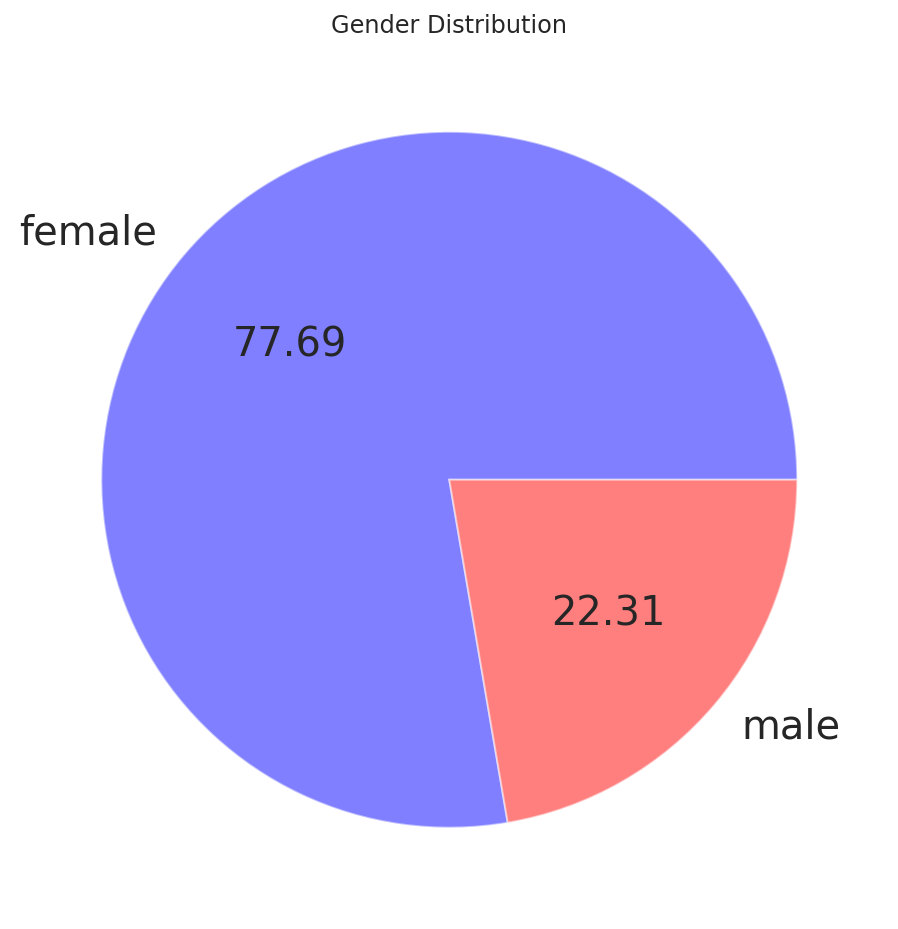

In [6]:
# plot gender distribution pie chart
gender_df = df.gender.value_counts()
 

gender_df.columns = ['gender']
gender_df.plot.pie(y = 'gender', 
                 colormap = 'bwr',
                 wedgeprops={'alpha':0.5},
                 figsize=(15,8), 
                 fontsize = 20, autopct = '%.2f',
                 legend = False,
                 title = 'Gender Distribution',
                 label='')

The average age of the participants is 24 years.

In [7]:
# let's check the average age of the participants
average_age = sum(df.age) / float(len(df.age))
average_age

24.1900826446281

In [8]:
df.gender.value_counts()

female    94
male      27
Name: gender, dtype: int64

In [9]:
# average age of both genders
df.groupby('gender', as_index=False).age.mean()

gender        age
0  female  23.702128
1    male  25.888889

Let's check the skeweness of the variables by plotting the distribution plots. It seems that the dataset contains mostly adults in the age group between 20 to 40 years old.

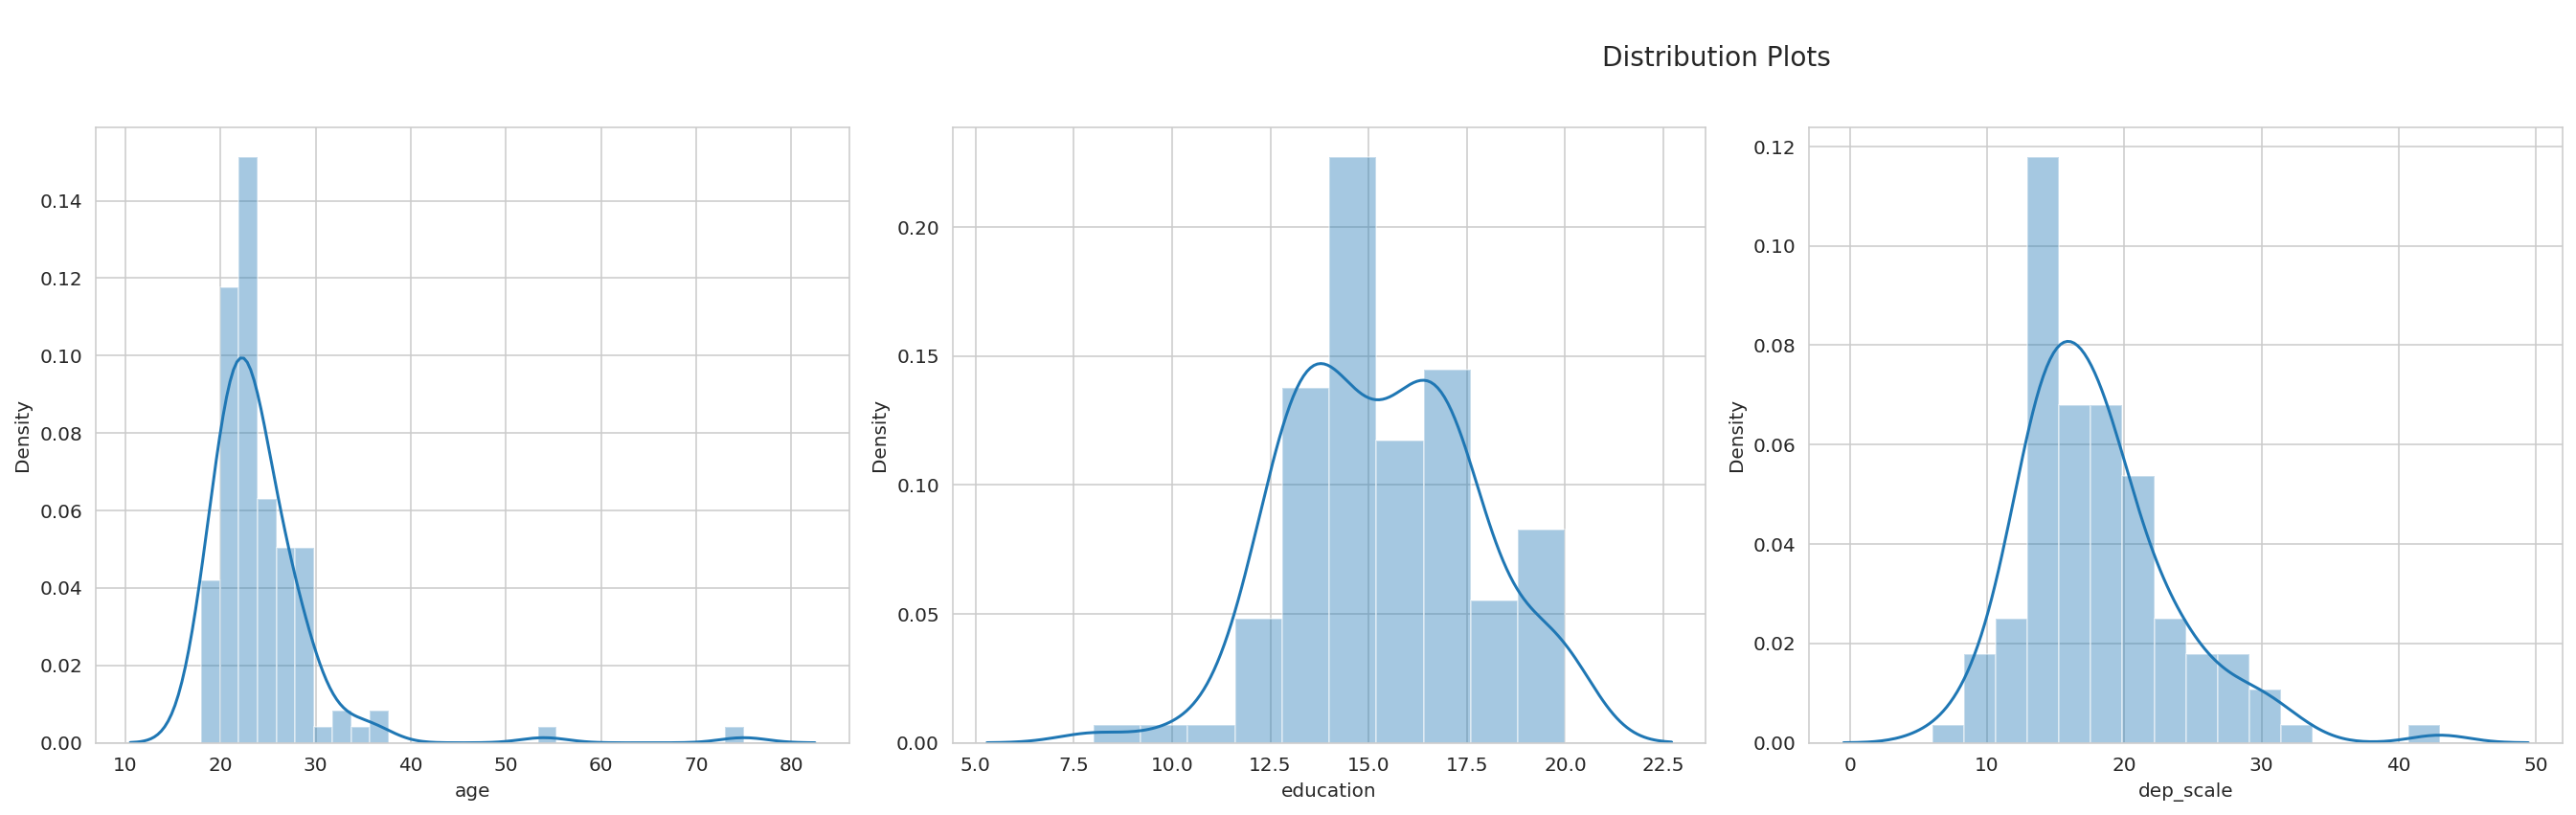

In [10]:
# plot distribution plots
plt.figure(figsize=(25,6))
plt.subplot(1, 4, 1)
sns.distplot(df['age'])

plt.subplot(1, 4, 2)
sns.distplot(df['education'])

plt.subplot(1, 4, 3)
sns.distplot(df['dep_scale'])

plt.suptitle('\nDistribution Plots\n', fontsize=14);
plt.tight_layout()

plt.show()

### Feature Engineering

Let's create a column that would indicate whether a person is depressed or not based on the depression scale. 

In [11]:
# create binary column 'depressed'
df['depressed'] = np.where(
    df['dep_scale'] <= 17, 0, np.where(
    df['dep_scale'] >  17, 1, None)) 
df["depressed"] = df["depressed"].astype(int)

In [12]:
df.depressed.value_counts()

0    65
1    56
Name: depressed, dtype: int64

It seems that people in the age between 20 to 30 years are more likely to be depressed than any other group.

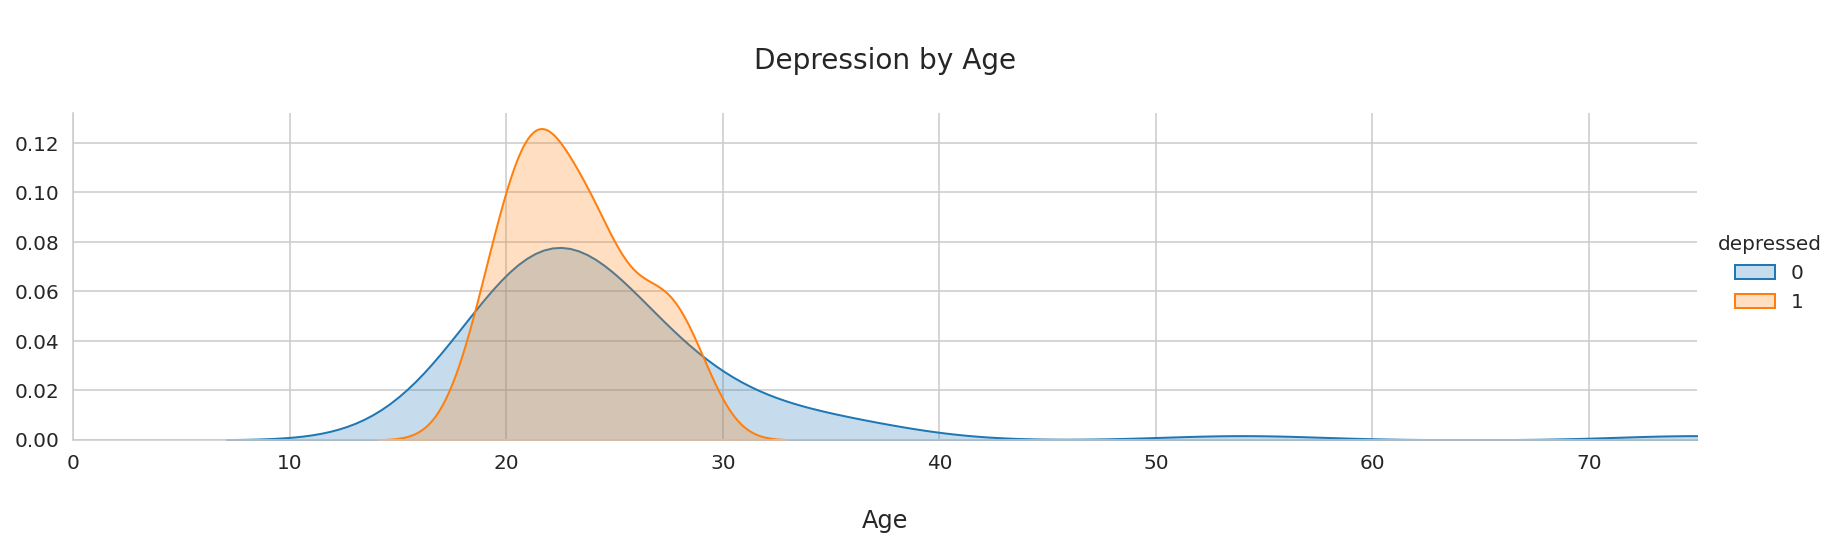

In [13]:
# plot depression by age plot
facet = sns.FacetGrid(df,hue="depressed", aspect=4)
facet.map(sns.kdeplot, 'age', shade=True)
facet.set(xlim=(0,df['age'].max()))
facet.add_legend()

plt.xlabel('\nAge', fontsize=12)
plt.title('\nDepression by Age\n', fontsize=14);

plt.show()

There seems to be no clear dependency between the level of education and depression. However, people are more likely to be depressed in the middle of the educational career. Moreover, the level of depression tends to decrease towards the end of the educational path.

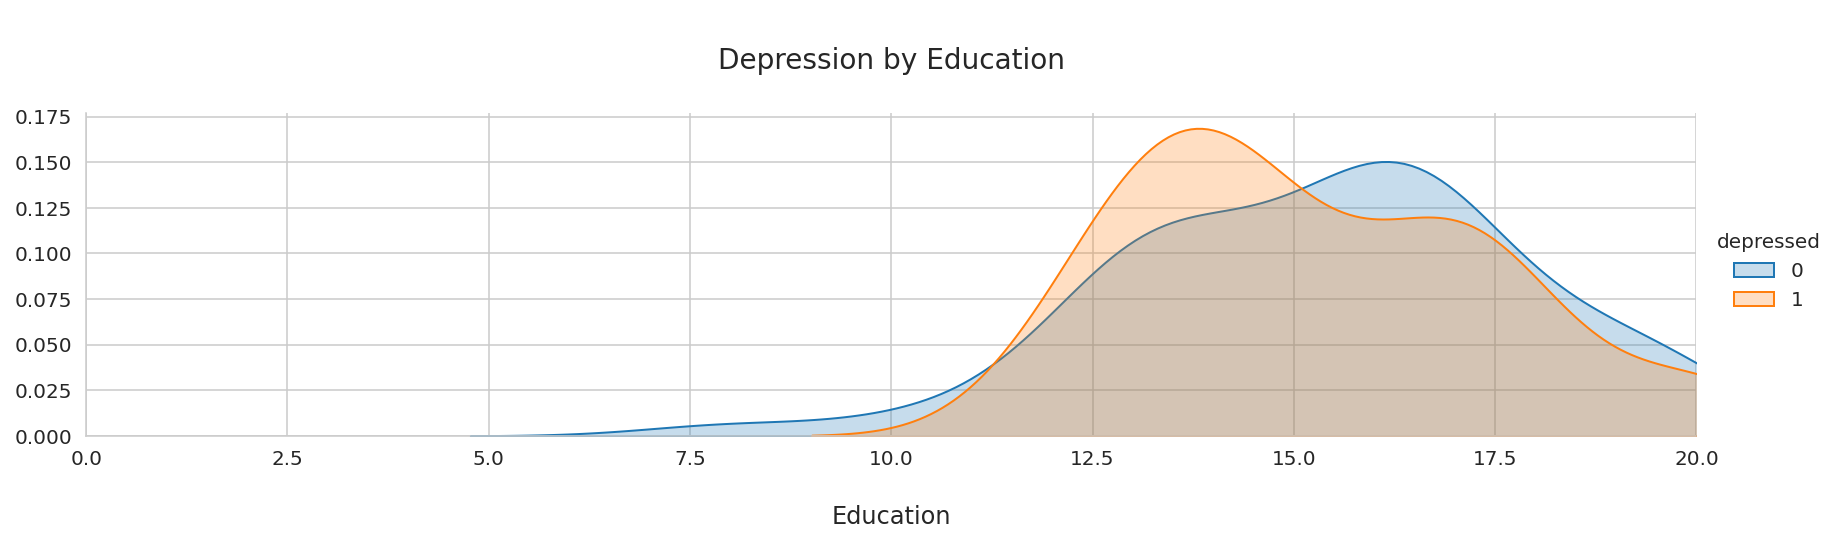

In [14]:
# plot depression by education plot
facet = sns.FacetGrid(df,hue="depressed", aspect=4)
facet.map(sns.kdeplot, 'education', shade=True)
facet.set(xlim=(0,df['education'].max()))
facet.add_legend()

plt.xlabel('\nEducation', fontsize=12)
plt.title('\nDepression by Education\n', fontsize=14);

plt.show()

It appears that females are more deppresed than males.

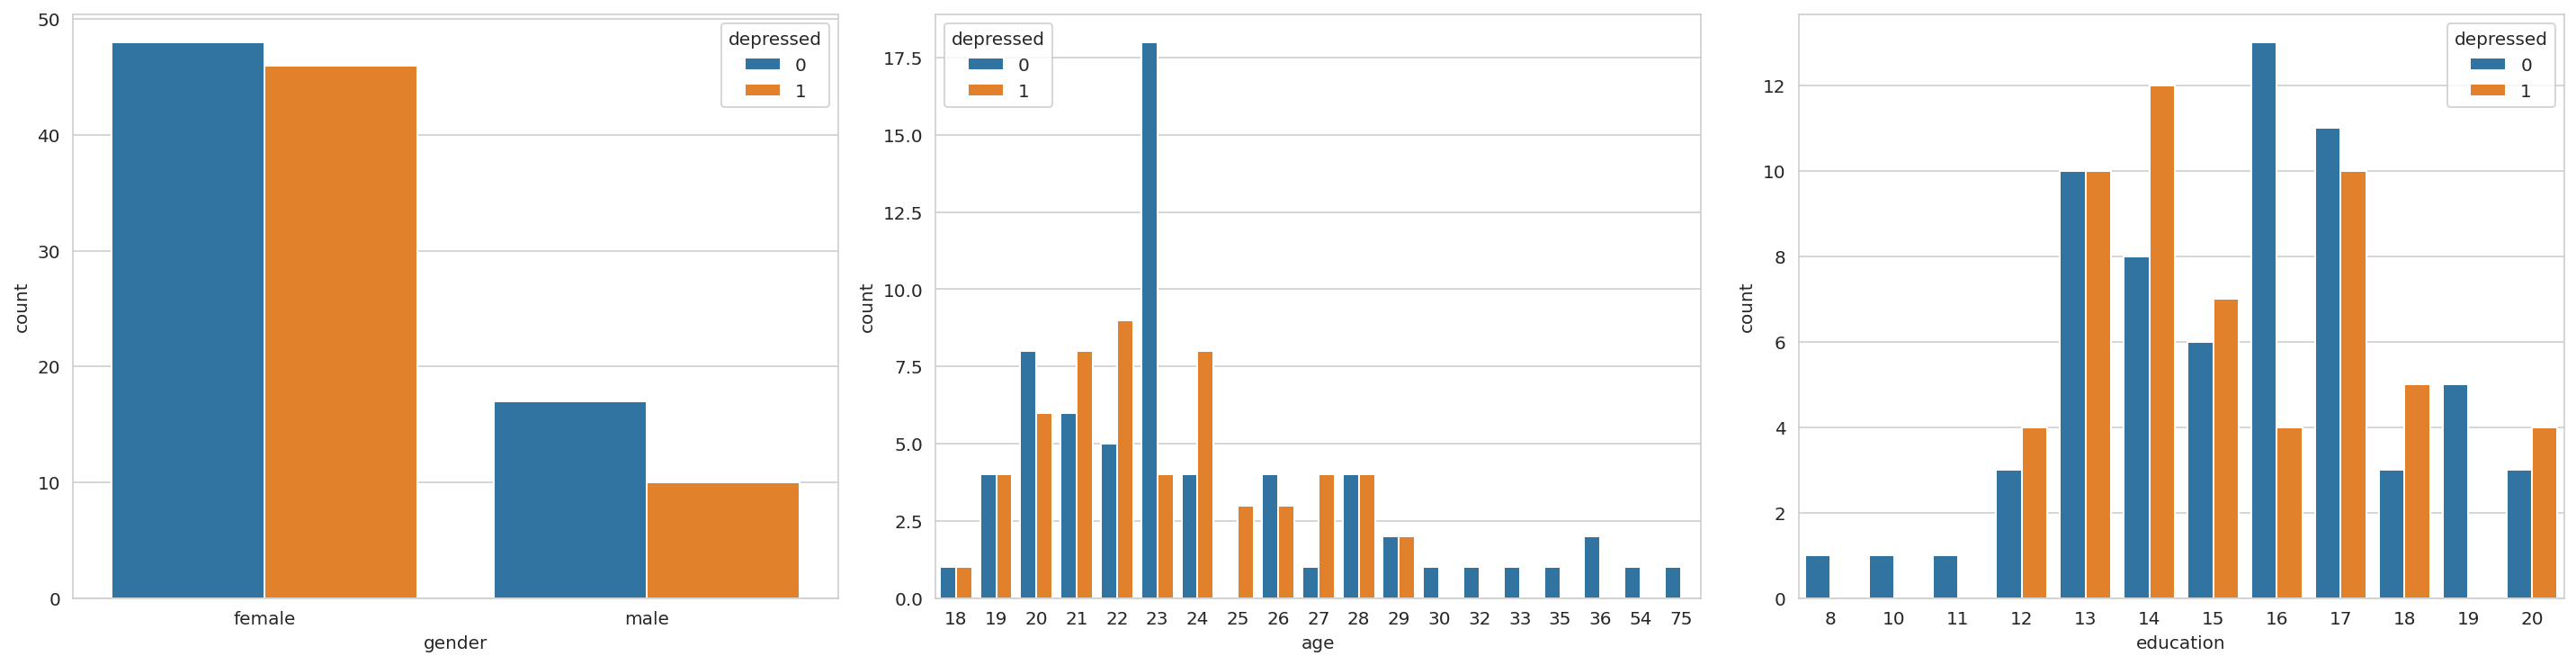

In [15]:
# plot pairplots
plt.figure(figsize=(20,15))

plt.subplot(3,3,1)
sns.countplot(x='gender', hue='depressed', data=df)
plt.subplot(3,3,2)
sns.countplot(x='age', hue='depressed', data=df)
plt.subplot(3,3,3)
sns.countplot(x='education', hue='depressed', data=df)

plt.tight_layout()
plt.show()

Here we can see that the older participants with higher education are less likely to get depressed.

<Figure size 1800x432 with 0 Axes>

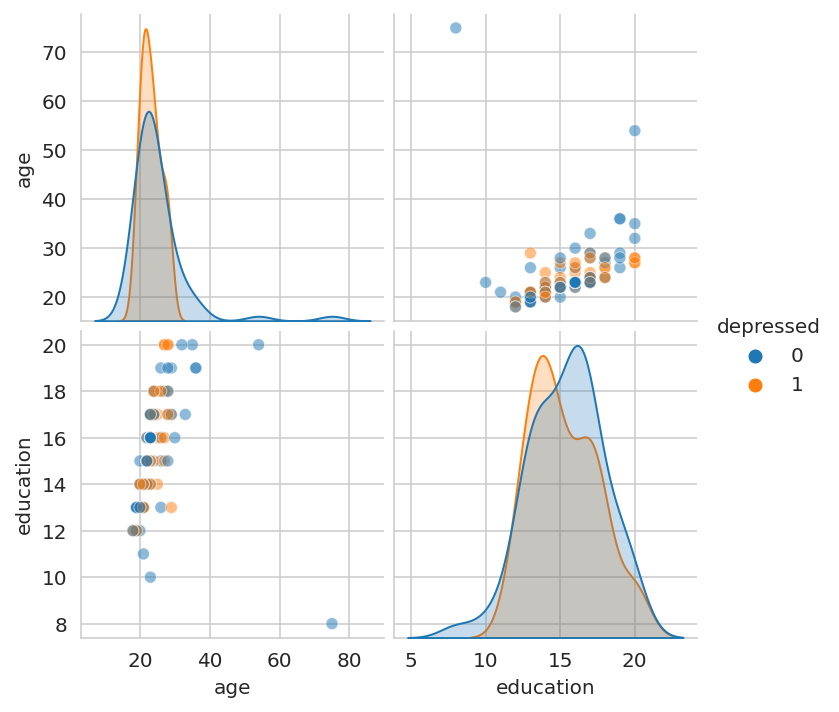

In [16]:
# plot pairplot
dfPairplot = df[["gender", "age", "education", "depressed"]]
dfPairplot.head()
plt.figure(figsize=(25,6))
sns.pairplot(data=dfPairplot, hue='depressed', plot_kws={'alpha':0.5})
plt.show()

Let's see the mean depression levels for different ages. It appears that female participants are the most depressed in the ages of 18 to 21, while male participants are the most depressed in the ages of 27-29.

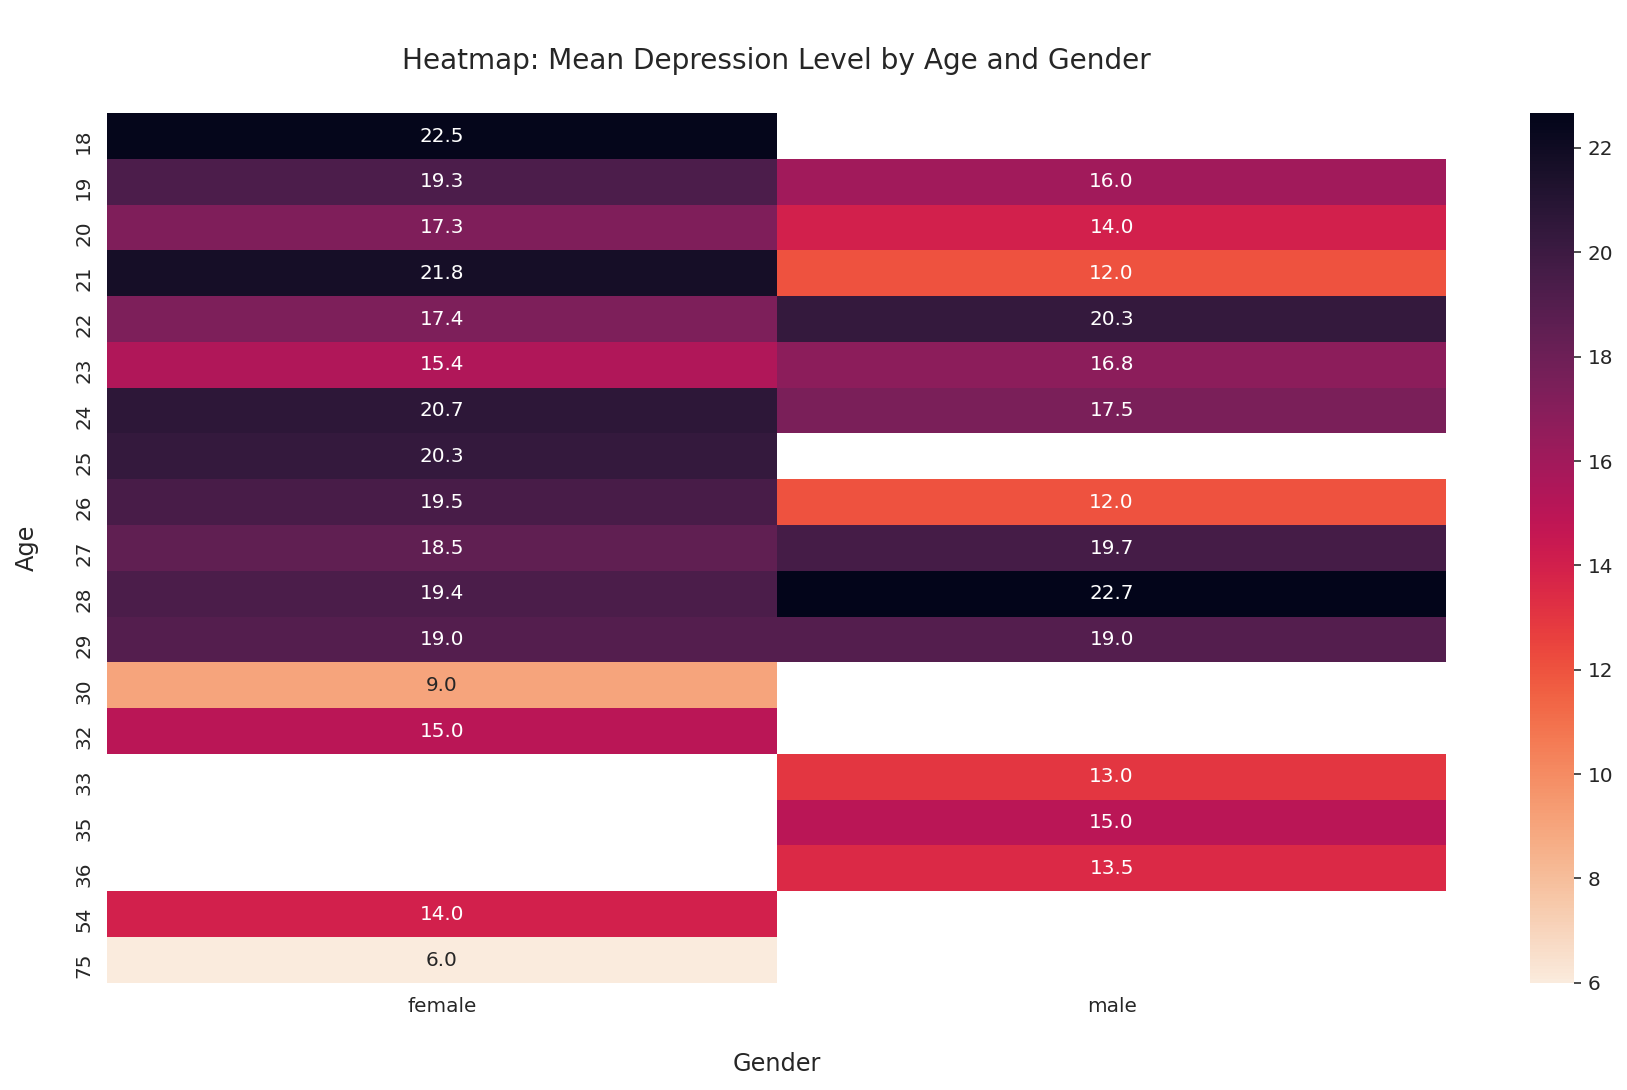

In [17]:
# plot heatmap of mean depression level by age and gender
plt.figure(figsize=(15,8))
sns.heatmap(df.groupby(['age', 'gender']).dep_scale.mean().unstack(), annot=True, fmt=".1f", cmap = sns.cm.rocket_r)

plt.xlabel('\nGender', fontsize=12)
plt.ylabel('Age\n', fontsize=12)
plt.title('\nHeatmap: Mean Depression Level by Age and Gender\n', fontsize=14);

Let's see the correlation matrix between the features to see with which features is depression the most correlated. We take all of the demographic features and several speech features. We can see that the depression is the most correlated with one of the speech variables, but not with the demographical features.

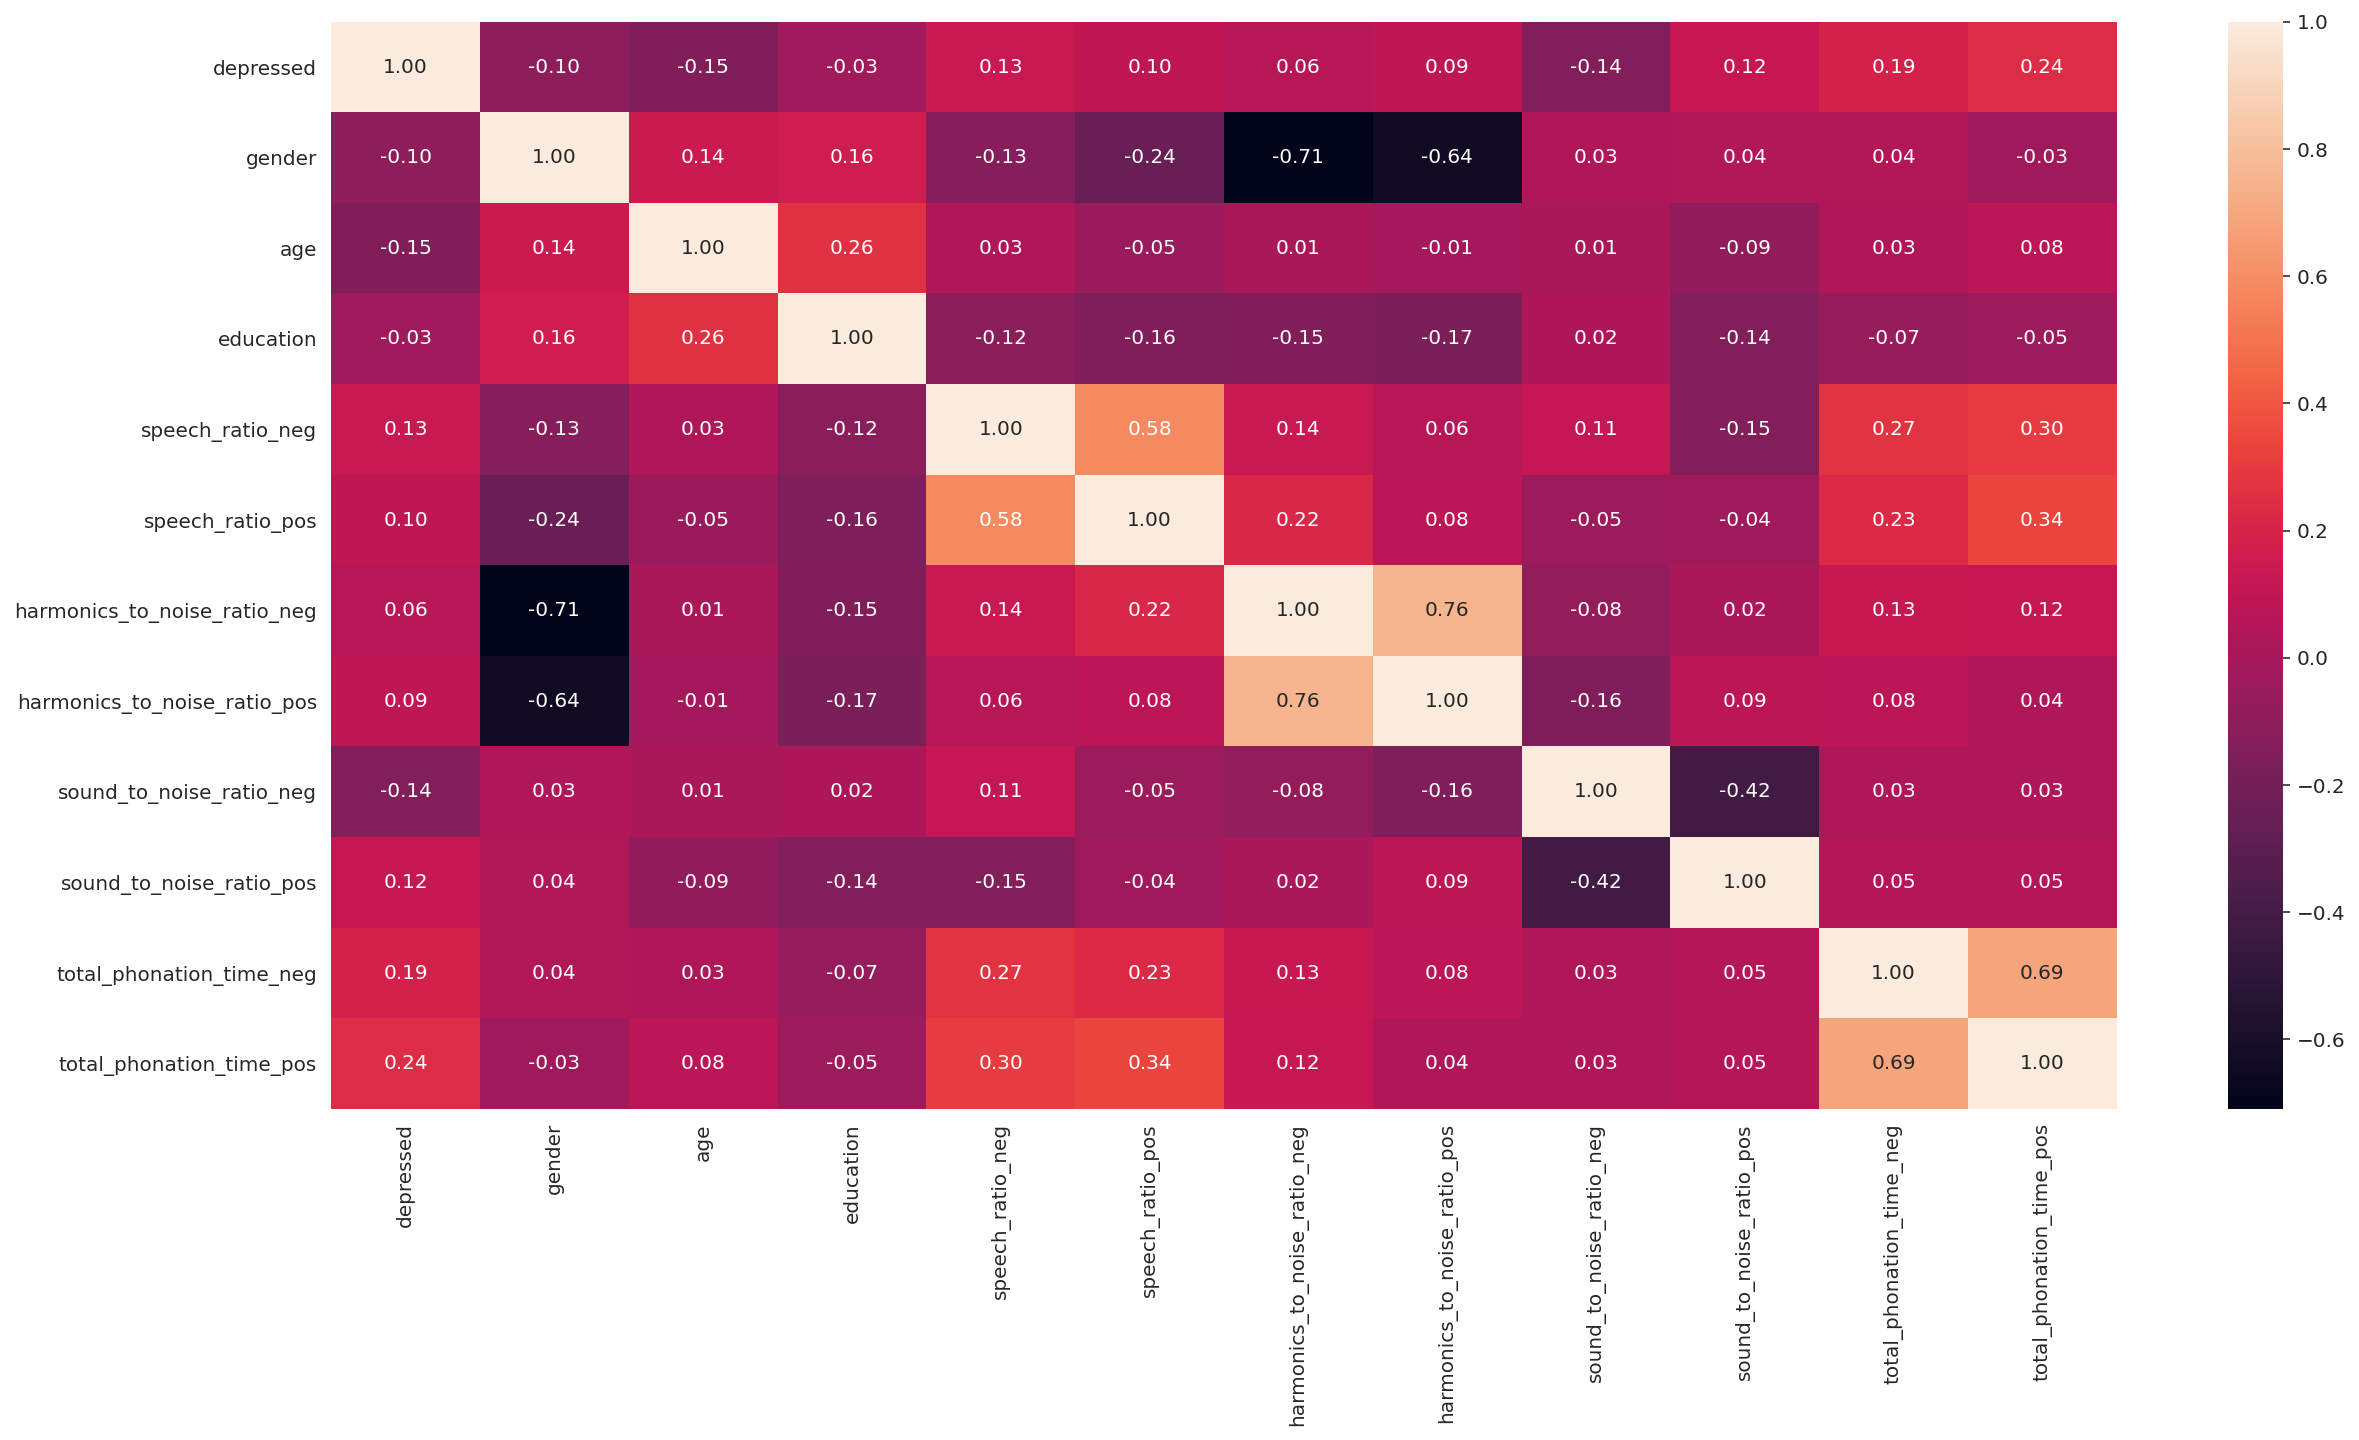

In [18]:
df_corr_columns = ['depressed','gender', 'age', 'education', 'speech_ratio_neg', 
                    'speech_ratio_pos', 'harmonics_to_noise_ratio_neg', 'harmonics_to_noise_ratio_pos', 
                    'sound_to_noise_ratio_neg', 'sound_to_noise_ratio_pos',
                    'total_phonation_time_neg', 'total_phonation_time_pos',
                    ]
dfCorr = pd.DataFrame(df, columns = df_corr_columns)

# convert the categorical variable gender into binary variables.
genders = {'female': 0,'male': 1}
dfCorr.gender = [genders[item] for item in dfCorr.gender]



# dfCorr = df.drop(['id'], axis=1)
plt.subplots(figsize=(20,10)) 
sns.heatmap(dfCorr.corr(), annot = True, fmt = ".2f")
plt.show()

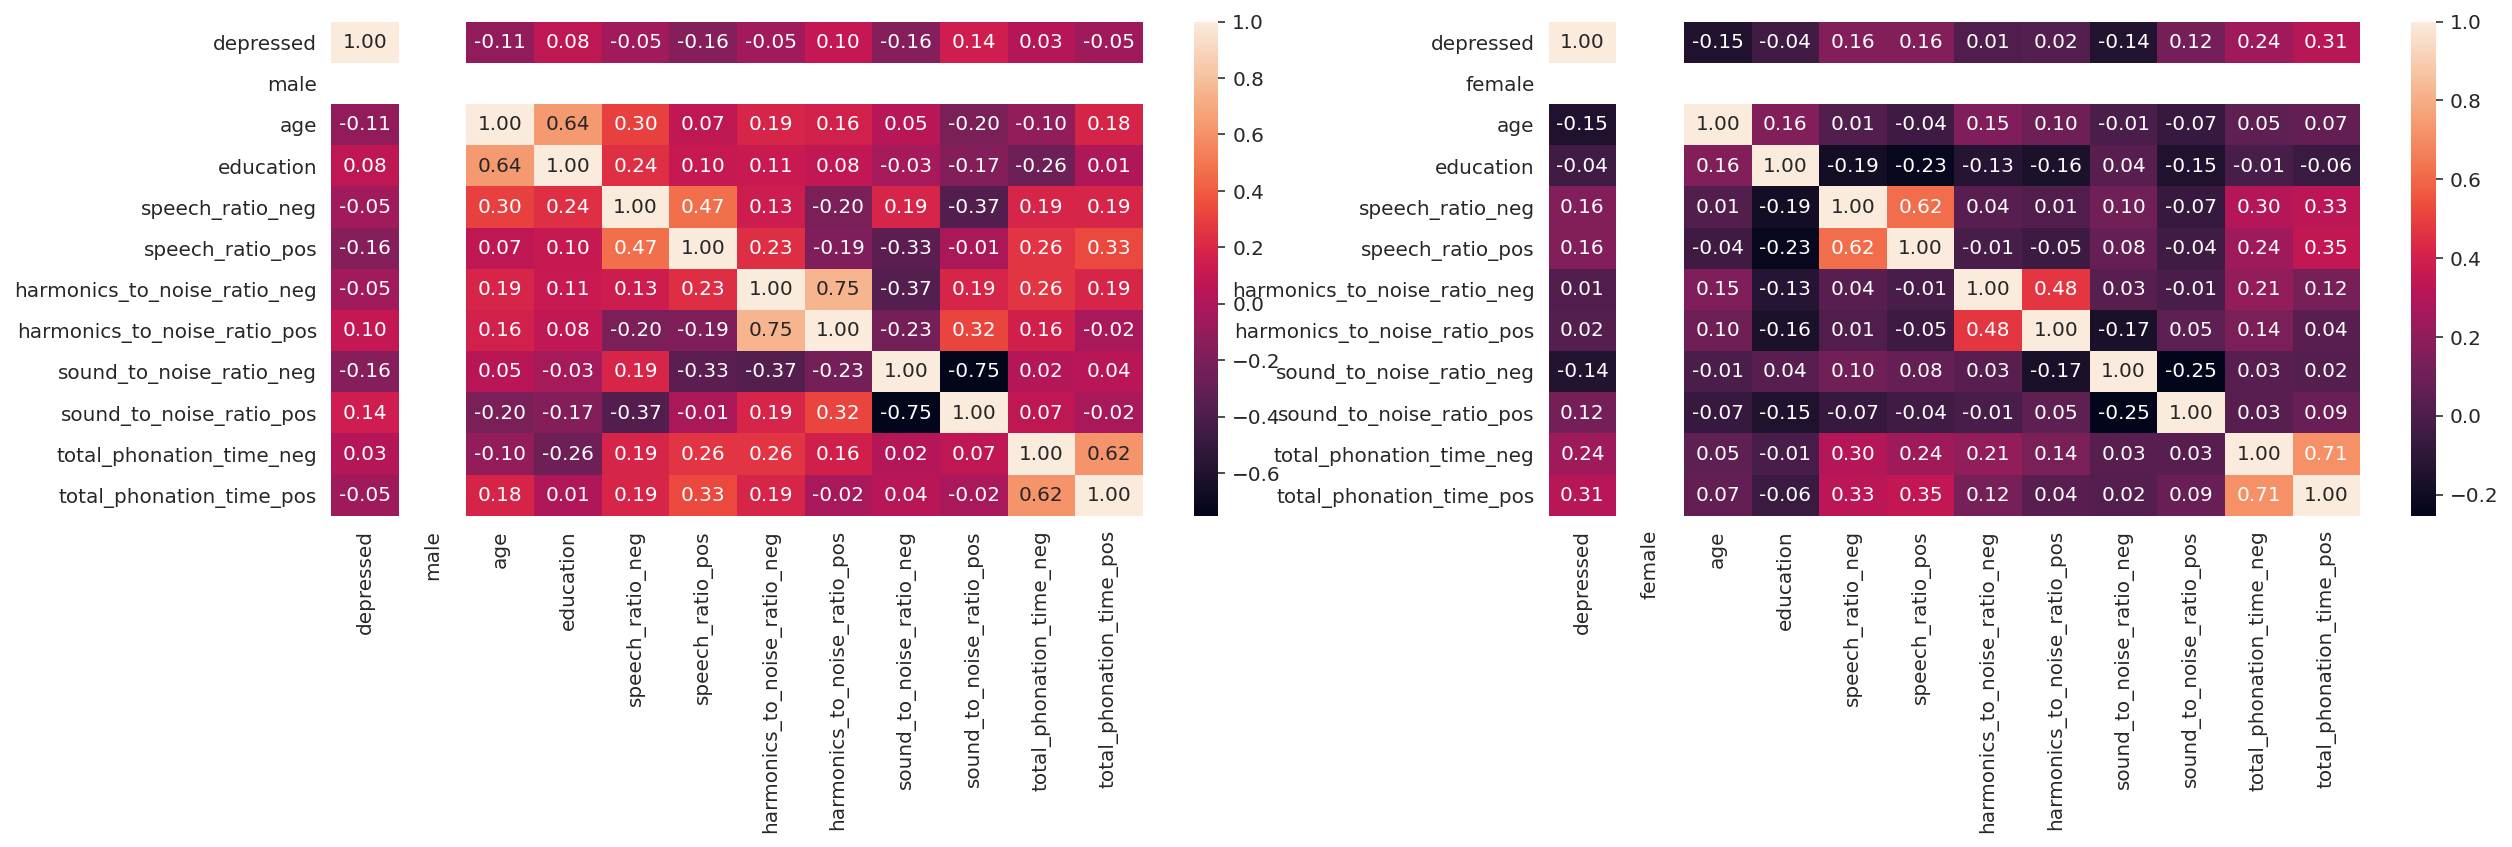

In [19]:
dfMale = dfCorr[dfCorr.gender != 0]
# print(dfMale.head())
dfFemale = dfCorr[dfCorr.gender != 1]

dfMale = dfMale.rename(columns = {'gender': 'male'}, inplace = False)
dfFemale = dfFemale.rename(columns = {'gender': 'female'}, inplace = False)


plt.subplots(figsize=(20,10)) 
plt.subplot(221)
sns.heatmap(dfMale.corr(), annot = True, fmt = ".2f") 
plt.subplot(222)

sns.heatmap(dfFemale.corr(), annot = True, fmt = ".2f")



plt.show()


# Data Pre-processing

### Handling Missing Values

Let's check if there are any missing values, which are represented with NaN or None.

As we can see, we have ten columns with 10-12 missing values representing speech variables. The columns represent five kinds of jitter measurements, which are acoustic characteristics of voice signals.

In [20]:
# display all rows of the dataframe
pd.set_option('display.max_rows', None)

# count NaN values for the columns
df.isna().sum()

id                                      0
age                                     0
gender                                  0
education                               0
dep_scale                               0
speech_ratio_neg                        0
speech_ratio_pos                        0
harmonics_to_noise_ratio_neg            0
harmonics_to_noise_ratio_pos            0
sound_to_noise_ratio_neg                0
sound_to_noise_ratio_pos                0
mean_f0_neg                             0
mean_f0_pos                             0
sd_f0_neg                               0
sd_f0_pos                               0
total_phonation_time_neg                0
total_phonation_time_pos                0
number_of_pauses_neg                    0
number_of_pauses_pos                    0
espinola_zero_crossing_metric_neg       0
espinola_zero_crossing_metric_pos       0
average_amplitude_change_neg            0
average_amplitude_change_pos            0
amplitude_mav_neg                 

Let's look at the missing values. The values are probably missing because the speech wasn't decoded for these features. This means that the nature of the missing data is not related to any of the variables, whether missing or observed. 

Since we don't have that many participants, we don't want to drop the rows with missing values. So, it makes sense to guess what the value might have been based on the other values in that column and row rather than just leaving them as NA's. This is called "imputation".

In [21]:
missing_rows = df[df.isna().any(axis=1)]
missing_rows.head()

id  age  gender  education  dep_scale  speech_ratio_neg  \
6   2290   35    male         20         15          0.817545   
34  2477   26    male         13         16          0.768009   
35  2478   26  female         16         22          0.887169   
36  2480   23  female         16         15          0.869176   
39  2491   20  female         13         19          0.942389   

    speech_ratio_pos  harmonics_to_noise_ratio_neg  \
6           0.832243                      8.966488   
34          0.792770                      9.907320   
35          0.938763                     11.431016   
36          0.873036                      9.984726   
39          0.922694                      9.778137   

    harmonics_to_noise_ratio_pos  sound_to_noise_ratio_neg  ...  \
6                       9.184509                  0.000017  ...   
34                     11.738011                 -0.000004  ...   
35                      8.578413                  0.000008  ...   
36                     12.254087                  0.000006  ...   
39                     10.967322                 -0.000001  ...   

    mean_cluster_density_pos  biggest_cluster_density_neg  \
6                      452.0                          214   
34                     428.0                          110   
35                     418.0                          155   
36                     238.0                          159   
39                     327.0                          401   

    biggest_cluster_density_pos  number_cluster_switches_neg  \
6                           452                            0   
34                          428                            0   
35                          418                            0   
36                          238                            0   
39                          327                            0   

    number_cluster_switches_pos  tangentiality_score_neg  \
6                             0                 0.434428   
34                            0                 0.500555   
35                            0                 0.577511   
36                            0                 0.396110   
39                            0                 0.522372   

    tangentiality_score_pos  coherence_metric_neg  coherence_metric_pos  \
6                  0.544219              1.058824              1.037267   
34                 0.501935              1.041096              0.996390   
35                 0.452631              0.991304              1.047059   
36                 0.491296              0.879310              0.830409   
39                 0.497784              0.950000              0.945148   

    depressed  
6           0  
34          0  
35          1  
36          0  
39          1  

[5 rows x 216 columns]

The missing values represent only 0.4% of the dataset.

In [22]:
# calculate total missing values
total_cells = np.product(df.shape)
total_missing = df.isna().sum().sum()

# calculate percent of data that is missing
(total_missing/total_cells) * 100

0.42087542087542085

Let's convert the categorical variable gender into binary and drop the ID of the participants as we don't need it for predicting.

In [23]:
# convert the categorical variable gender into binary variables.
genders = {'female': 0,'male': 1}
df.gender = [genders[item] for item in df.gender]

# use pandas get_dummies function to assign binary variables.
education_level = pd.get_dummies(df.education).astype(int)

# drop id and education columns
df = df.drop(['id', 'education'], axis = 1)

# drop the original columns and replace them with indicator columns
df = pd.concat((df, education_level), axis = 1)

Let's use Multiple Imputation using MICE (Multiple Imputation by Chained Equations) to impute the missing data. Multiple imputation is a process where the missing values are filled multiple times to create “complete” datasets. Multiple imputation has a lot of advantages over traditional single imputation methods (e.g., mean, median). 

Multiple Imputation by Chained Equations (MICE) is an imputation method that works with the assumption that the missing data are Missing at Random (MAR). Recall that for MAR, the nature of the missing data is related to the observed data but not the missing data. The MICE algorithm works by running multiple regression models and each missing value is modeled conditionally depending on the observed (non-missing) values.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/
https://impyute.readthedocs.io/en/latest/_modules/impyute/imputation/cs/mice.html
https://medium.com/@WalePhenomenon/missing-data-conundrum-exploration-and-imputation-techniques-9f40abe0fd87


In [24]:
# start the MICE training
imputed_training=mice(df.values)

In [25]:
# convert numpy array to dataframe
df = pd.DataFrame(data=imputed_training[0:,0:],     # values
                columns=df.columns)                 # 1st row as the column names

print("The dataset has {} rows and {} columns after being preprocessed.".format(*df.shape))

The dataset has 121 rows and 226 columns after being preprocessed.


In [26]:
# count number of rows with at least one missing value
missing_rows = sum(df.apply(lambda x: sum(x.isnull().values), axis = 1)>0)

if missing_rows == 0:
    print("There are no missing values in the dataset.")

There are no missing values in the dataset.


In [27]:
df.head()

age  gender  dep_scale  speech_ratio_neg  speech_ratio_pos  \
0  22.0     0.0       16.0          0.907169          0.895368   
1  21.0     0.0       15.0          0.883506          0.879200   
2  21.0     0.0       23.0          0.863110          0.841594   
3  23.0     1.0       12.0          0.842673          0.836735   
4  28.0     1.0       15.0          0.819487          0.625387   

   harmonics_to_noise_ratio_neg  harmonics_to_noise_ratio_pos  \
0                     12.267561                     11.590832   
1                     14.369169                      6.955338   
2                     13.401637                     12.859636   
3                      4.736998                      5.777533   
4                      5.536166                      5.677916   

   sound_to_noise_ratio_neg  sound_to_noise_ratio_pos  mean_f0_neg  ...   11  \
0                  0.000002                  0.000028   142.296196  ...  0.0   
1                  0.000019                 -0.000014   159.200215  ...  0.0   
2                  0.000020                 -0.000024   152.300449  ...  0.0   
3                  0.000067                  0.000018    72.299336  ...  0.0   
4                  0.000200                 -0.000116    78.234402  ...  0.0   

    12   13   14   15   16   17   18   19   20  
0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  

[5 rows x 226 columns]

### Outlier Detection

Let's start by exploring the demographic variables, such as age of the participants before moving to other features.

In [28]:
# check the mean age of the participants
df['age'].describe()

count    121.000000
mean      24.190083
std        6.513210
min       18.000000
25%       21.000000
50%       23.000000
75%       26.000000
max       75.000000
Name: age, dtype: float64

Let's plot the age distribution box. The 75% of the participants are up to 26 years old, but the maximum age is 75 let's decide on a limit of 40 years old, and drop all outliers that are older than that.

<AxesSubplot:title={'center':'Age\n'}>

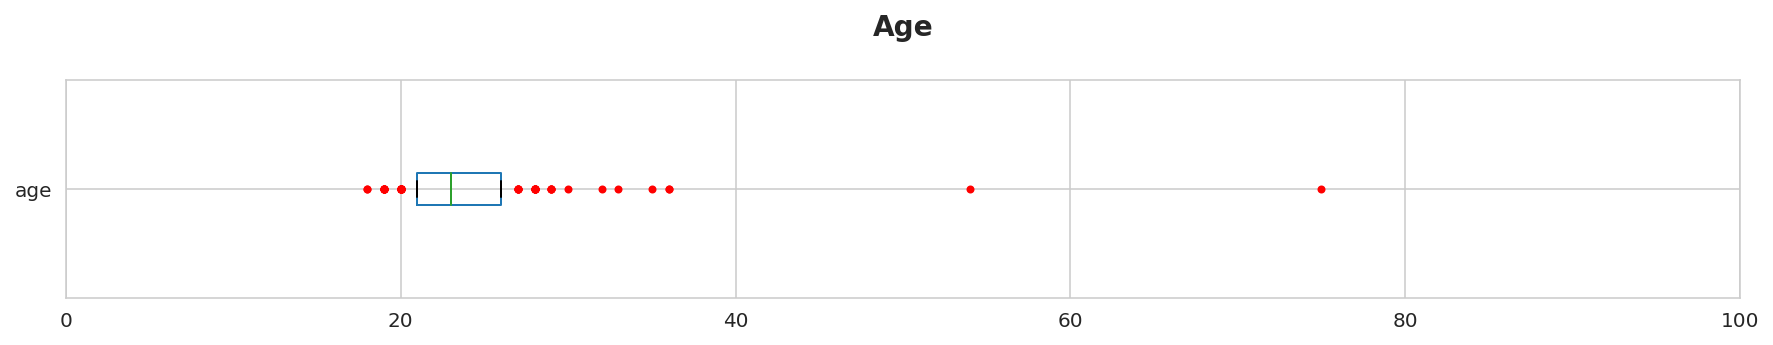

In [29]:
# plot the price distribution box after dropping the listings
box_plot = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
age_dist = df['age'].plot(kind='box', xlim=(0,100), vert=False, flierprops=box_plot, whis=0.05, figsize=(15,2));
plt.title('Age\n', fontsize=14, fontweight='bold')
age_dist

In [30]:
df.drop(df[(df.age > 40)].index, axis=0, inplace=True)
print("The dataset has {} rows and {} columns - after dropping irrelevant rows.".format(*df.shape))

The dataset has 119 rows and 226 columns - after dropping irrelevant rows.


<AxesSubplot:title={'center':'Age\n'}>

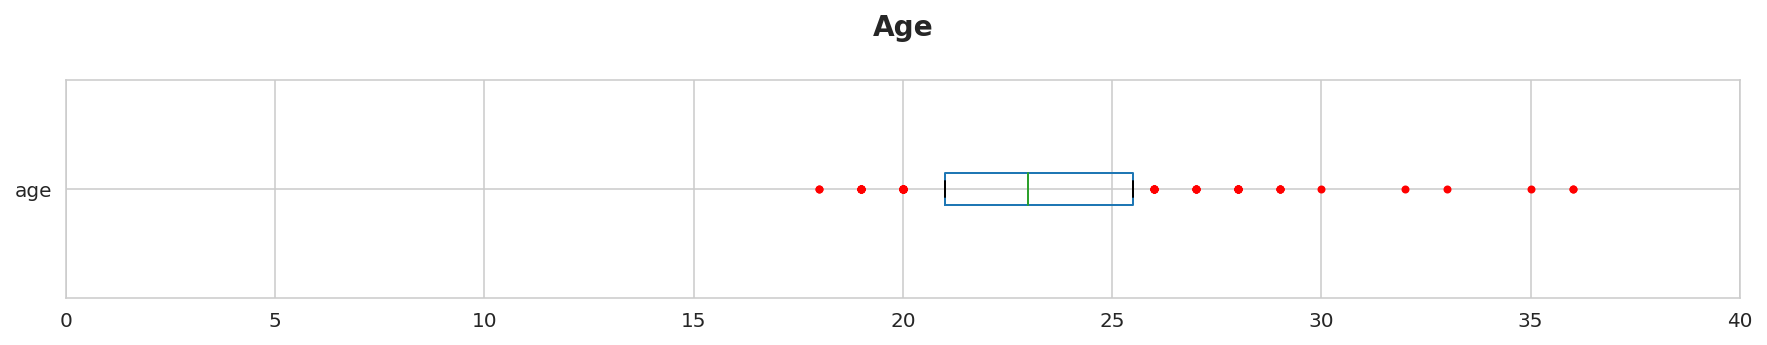

In [31]:
# plot the price distribution box after dropping the listings
box_plot = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
age_dist = df['age'].plot(kind='box', xlim=(0,40), vert=False, flierprops=box_plot, whis=0.05, figsize=(15,2));
plt.title('Age\n', fontsize=14, fontweight='bold')
age_dist

Next, let's check the correlations between our numerical features and see which features are very highly correlated. In this case we will select a correlation of 90 and above.&nbsp;We can use a correlation matrix and convert the correlations to their absolute values in order to deal with negative correlations. 

In [32]:
df_copy = df.copy()
corr_matrix = df_copy.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

age    gender  dep_scale  \
age                                  NaN  0.354896   0.100655   
gender                               NaN       NaN   0.122212   
dep_scale                            NaN       NaN        NaN   
speech_ratio_neg                     NaN       NaN        NaN   
speech_ratio_pos                     NaN       NaN        NaN   
harmonics_to_noise_ratio_neg         NaN       NaN        NaN   
harmonics_to_noise_ratio_pos         NaN       NaN        NaN   
sound_to_noise_ratio_neg             NaN       NaN        NaN   
sound_to_noise_ratio_pos             NaN       NaN        NaN   
mean_f0_neg                          NaN       NaN        NaN   
mean_f0_pos                          NaN       NaN        NaN   
sd_f0_neg                            NaN       NaN        NaN   
sd_f0_pos                            NaN       NaN        NaN   
total_phonation_time_neg             NaN       NaN        NaN   
total_phonation_time_pos             NaN       NaN        NaN   
number_of_pauses_neg                 NaN       NaN        NaN   
number_of_pauses_pos                 NaN       NaN        NaN   
espinola_zero_crossing_metric_neg    NaN       NaN        NaN   
espinola_zero_crossing_metric_pos    NaN       NaN        NaN   
average_amplitude_change_neg         NaN       NaN        NaN   
average_amplitude_change_pos         NaN       NaN        NaN   
amplitude_mav_neg                    NaN       NaN        NaN   
amplitude_mav_pos                    NaN       NaN        NaN   
amplitude_kurtosis_neg               NaN       NaN        NaN   
amplitude_kurtosis_pos               NaN       NaN        NaN   
amplitude_third_moment_neg           NaN       NaN        NaN   
amplitude_third_moment_pos           NaN       NaN        NaN   
amplitude_fourth_moment_neg          NaN       NaN        NaN   
amplitude_fourth_moment_pos          NaN       NaN        NaN   
max_amplitude_neg                    NaN       NaN        NaN   
max_amplitude_pos                    NaN       NaN        NaN   
peak_frequency_neg                   NaN       NaN        NaN   
peak_frequency_pos                   NaN       NaN        NaN   
power_spectrum_ratio_neg             NaN       NaN        NaN   
power_spectrum_ratio_pos             NaN       NaN        NaN   
mean_power_neg                       NaN       NaN        NaN   
mean_power_pos                       NaN       NaN        NaN   
total_power_neg                      NaN       NaN        NaN   
total_power_pos                      NaN       NaN        NaN   
average_mfccs_1_neg                  NaN       NaN        NaN   
average_mfccs_2_neg                  NaN       NaN        NaN   
average_mfccs_3_neg                  NaN       NaN        NaN   
average_mfccs_4_neg                  NaN       NaN        NaN   
average_mfccs_5_neg                  NaN       NaN        NaN   
average_mfccs_6_neg                  NaN       NaN        NaN   
average_mfccs_7_neg                  NaN       NaN        NaN   
average_mfccs_8_neg                  NaN       NaN        NaN   
average_mfccs_9_neg                  NaN       NaN        NaN   
average_mfccs_10_neg                 NaN       NaN        NaN   
average_mfccs_11_neg                 NaN       NaN        NaN   
average_mfccs_12_neg                 NaN       NaN        NaN   
average_mfccs_13_neg                 NaN       NaN        NaN   
average_mfccs_14_neg                 NaN       NaN        NaN   
average_mfccs_15_neg                 NaN       NaN        NaN   
average_mfccs_16_neg                 NaN       NaN        NaN   
average_mfccs_17_neg                 NaN       NaN        NaN   
average_mfccs_18_neg                 NaN       NaN        NaN   
average_mfccs_19_neg                 NaN       NaN        NaN   
average_mfccs_20_neg                 NaN       NaN        NaN   
average_mfccs_1_pos                  NaN       NaN        NaN   
average_mfccs_2_pos                  NaN       NaN        NaN   
average

We see that the following columns have very high correlation. We might need to drop them later to improve the predictions as they don't provide much predictive ability.

In [33]:
to_drop = [var for var in upper.columns if any(upper[var] > .95)]
to_drop

['number_of_pauses_neg',
 'number_of_pauses_pos',
 'mean_power_neg',
 'mean_power_pos',
 'total_power_neg',
 'total_power_pos',
 'jitter_ppq5_neg',
 'jitter_ddp_neg',
 'jitter_ppq5_pos',
 'jitter_ddp_pos',
 'avg_dependencies_neg',
 'avg_dependencies_pos',
 'mean_cluster_density_neg',
 'mean_cluster_density_pos',
 'biggest_cluster_density_neg',
 'biggest_cluster_density_pos',
 'number_cluster_switches_neg',
 'number_cluster_switches_pos']

### Normalization

Next, we want to scale the numeric features. We will use MinMaxScaler to accomplish this and change the range of each features to 0 till 1.

Most classifiers use some form of a distance calculation and each numeric feature tends to have different ranges. Scaling these features helps ensure that each feature’s contribution is weighted proportionally.&nbsp;

In [34]:
# pulling out numeric features for normalizing
categ_feats = ['depressed', 'gender', 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
df_categ_feats = pd.DataFrame(df, columns = categ_feats)
df_numeric_feats = df.drop(columns = categ_feats)

# normalizing numeric features and converting back to dataframe
min_max_scaler = preprocessing.MinMaxScaler()
normalized_numeric_feats = min_max_scaler.fit_transform(df_numeric_feats)
normalized_numeric_feats = pd.DataFrame(normalized_numeric_feats, columns = df_numeric_feats.columns, index=df_categ_feats.index)

# creating new dataframe with categorical features and the normalized numeric features
df = pd.concat([df_categ_feats, normalized_numeric_feats], axis=1)

In [35]:
df.head()

depressed  gender    8   10   11   12   13   14   15   16  ...  \
0        0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...   
1        0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   
2        1.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   
3        0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...   
4        0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

   mean_cluster_density_neg  mean_cluster_density_pos  \
0                  0.002676                  0.127771   
1                  0.091459                  0.003911   
2                  0.077773                  0.090613   
3                  0.002171                  0.000745   
4                  0.000500                  0.000261   

   biggest_cluster_density_neg  biggest_cluster_density_pos  \
0                     0.022222                     0.122047   
1                     0.086772                     0.017717   
2                     0.073016                     0.084646   
3                     0.010582                     0.013780   
4                     0.002116                     0.000000   

   number_cluster_switches_neg  number_cluster_switches_pos  \
0                     0.426966                     0.000000   
1                     0.000000                     0.300000   
2                     0.000000                     0.000000   
3                     0.651685                     0.536364   
4                     0.067416                     0.072727   

   tangentiality_score_neg  tangentiality_score_pos  coherence_metric_neg  \
0                 0.637006                 0.092356              0.516746   
1                 0.752887                 0.275597              0.425513   
2                 0.587110                 0.528401              0.425513   
3                 0.689298                 0.369899              0.531686   
4                 1.000000                 0.754339              0.789474   

   coherence_metric_pos  
0              0.380395  
1              0.535448  
2              0.485332  
3              0.171343  
4              0.475954  

[5 rows x 226 columns]

# Data Modeling

### Classification Models

Our dataset explores a possible correlation between speech features and depression disorder. So, our goal is to construct a model that may accurately predict if a subject is depressed or not based on how they express memories of both negative and positive events.  Now since we are treating the depression value in the dataset as either being depressed (1) or not being depressed (0), we can simply use a binary classification model. (This comes at the cost of not being able to tell the severity of the depression, but makes it easier to predict) 

There exist a lot of good binary classification models. Here we describe several ones that we deemed to be the most important ones and we will look into their respective advantages and disadvantages with respect to our dataset in order to justify our choice of model(s).

### 1. Naive Bayes Model ###

Is a classification technique based on Bayes theorem, which describes the probability of an event, based on prior knowledge of conditions that might be related to the event. For example, we know that obese people are more likely to have a heart attack since we also know that they (probably) had a high fat and sugar diet, which is proven to clog vital arteries. The 'naive' part relates to the model's property to assume that all the features are independent, which is pretty rare in real-life. Take for example an apple: it's red, round, and about 3 inches in diameter. Even if these features depend on each other or upon the existence of the other features, all of these properties independently contribute to the probability that this fruit is an apple and that is why it is known as ‘Naive’.

key advantages:
- simple to implement
- doesn't require much training data
- handles both discrete and continuos data
- highly scalable
- very fast (can be used for real-time)
- not sensitive to irrelevant features! (probably due to the fact that features are independent)

key disadvantages:
- assumes that all features are independent of each other
- "zero-frequency" problem = assigns zero probability to category values whose category isn't prsent in training data

### 2. Logistic Regression ###
was mainly used in biological sciences during the early twentieth century. Logistic regression models is used if the dependent value (i.e. the result you wanna predict) is categorical, i.e. it can be expressed as either true (1) or false (0), which is the case for our project.

The key advantages of this model are:
- easy to implement
- very efficient to train
- good accuracy for simple datasets, especially if they are linearly seperable
- updated easily to reflect new data


key disadvantages:
- requires a large dataset
- if the #observations < #features -> overfitting
- linear boundaries (for model to be efficient)
- may not be able to predict accurate results on the test set
- Non linear problems can't be solved
- sensitive to outliers



### 3. K-nearest neighbors ###
The k-nearest neighbors (KNN) algorithm is a simple, supervised machine learning algorithm. It works by classifying objects into groups based on the object's nearest neighbors (k to be exact) in a feature space (for example in 2D this would be a plane and distance would be measured with euclidian distance usually).

key advantages:
- Quick calculation time
- simple to understand
- easy to add new data
- easy to implement, onyl 2 parameters (K and which distance function to use)

key disadvantages:
- does not work well with large datasets since the cost of calculating distance from every new point to every other point is huge
- does not work well with high dimensional datasets since distance becomes difficult to calculate
- needs feature scaling (normalization technique)
- sensitive to noisy, missing data and outliers

### 4. Support Vector Machine (SVM) ###
A support vector machine works by finding a hyperplane in an n-dimensional space (n being the # of variables) to seperate the data points. They say a picture says more than 1000 words so here we go:


![Picture title](image-20210421-224233.png) Ref: https://laptrinhx.com/svm-feature-selection-and-kernels-743434724/

key advantages:
- very good when we have no information on the data we are working with
- works well with unstructured data
- scales well with high dimensional dataset
- low risk of over fitting, even in higher dimensions
- usually compared to ANN, has better results

key disadvantages:
- long training time for large datasets
- difficult to udnerstand and interpret final model compared to other approaches (especially in high dimension)
- difficult to fine tune hyperparameters


### 5. Decision tree ###
Decision trees use a tree like structure to model decisions and their possible outcomes. They are a non-parametric supervised learning method used for classification and regression. Here is a simple example for a decision tree whether or not to go and play tennis: 

key advantages:
- requires almost no effort for data preparation
- does not require normalization
- does not require scaling
- missing values do not affect result
intuitive to understand and easy to explain final model

key disadvantages:
- small change in data -> large change in model structure
- large training time, high time&space complexity
- weak lerner (i.e. performs relatively poorly), often requires more than one tree -> forest

![Picture title](image-20210421-225115.png) Ref: https://www.geeksforgeeks.org/decision-tree/

There's also Boosting decision-trees, which are just an extension of regular decision trees. Boosting in this context means that each tree is dependent on prior trees, which increases perfomance.

### Conclusion ###

The plan is to use both a Support Vector Machine model as a baseline model and perform training on several more models. Then, we will see which one will perform the best on our data. 

# Data Modeling

### Splitting Data

To understand model performance, dividing the dataset into a training set and a test set is a good strategy. Let's split the dataset on training and testing sets. We will create two datasets with. The first dataset contains **only speech features**. The second dataset contains both **speech and non-speech features** (i.e., gemographic and clinical). 

We also drop the columns that have very high correlation (95 and above).

We use `test_size = 0.2`. We also use `random_state` to select records randomly.

In [36]:
# create target and features
demographic_clinical_feats = ['gender', 'dep_scale', 'age', 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
df_demographic_clinical_feats = pd.DataFrame(df, columns = demographic_clinical_feats)

# create dataframe with speech features
df_speech = df.drop(columns = demographic_clinical_feats)
df_speech = df_speech.drop(['depressed'], axis = 1)

# create dataframe with demographical, clinical and speech features
df_full = pd.concat([df_demographic_clinical_feats, df_speech], axis=1)
df_full = df_full.drop(['dep_scale'], axis = 1)

#drop features that are highly correlated
df_full = df_full.drop(columns = to_drop)
# df_speech = df_speech.drop(columns = to_drop)
# df_demographic_clinical = df_demographic_clinical_feats.drop(columns = to_drop)

df_full = df_full
df_speech = df_speech
df_demographic_clinical = df_demographic_clinical_feats



In [37]:
# create target label
df_target = df.depressed

# split our data
X_train, X_test, y_train, y_test = train_test_split(df_full, df_target, test_size=0.2, random_state=10)
X_train_speech, X_test_speech, y_train_speech, y_test_speech = train_test_split(df_speech, df_target, test_size=0.2, random_state=10)

# summarize the shape of the training datasets
print(X_train.shape, y_train.shape)
print(X_train_speech.shape, y_train_speech.shape)

(95, 206) (95,)
(95, 210) (95,)


In [38]:
print(X_test.shape, y_test.shape)
print(X_test_speech.shape, y_test_speech.shape)

(24, 206) (24,)
(24, 210) (24,)


### Outlier Detection

One of the next excersises for the outlier detection is to check distribution and outliers in the speech features. As we have many features, we need to develop an automated way to determine whether nor not these features contain skewed distributions and if they contain any outliers. There are various outlier techniques that can be used, such as Z-Score, Dbscan and Isolation Forests. We will use **Isolation Forests** for detecting outliers as 
- It is  convenient to use in a low dimensional feature space.
- It is an effective method when value distributions can not be assumed. 
- It has few parameters, this makes this method robust and easy to optimize.
- There is no need of scaling the values in the feature space.


https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561

https://towardsdatascience.com/how-to-detect-outliers-with-python-pyod-aa7147359e4b

In [39]:
#  identify outliers in the training dataset
iso = IsolationForest(contamination=0.05)
yhat = iso.fit_predict(X_train)

# select all rows that are not outliers
mask = yhat != -1
X_train, y_train = X_train.values[mask, :], y_train.values[mask]
X_train_speech, y_train_speech = X_train_speech.values[mask, :], y_train_speech.values[mask]

# summarize the shape of the updated training dataset
print(X_train.shape, y_train.shape)
print(X_train_speech.shape, y_train_speech.shape)

(90, 206) (90,)
(90, 210) (90,)


## Implementing Models ##

### 1. Support Vector Machine (SVM)

Let's build support vector machine model. First, import the SVM module and create support vector classifier object by passing argument kernel as the linear kernel in `SVC()` function. Then, we fit the model on train set using `fit()` and perform prediction on the test set using `predict()`.

In [40]:
#Create an svm Classifier
clf = SVC(kernel='linear') # Linear Kernel

# start time
start = time.time()

#Train the model using the training sets
clf.fit(X_train, y_train)

# check training time
print("Train time: {0}".format(time.time() - start))

_model_SVM_dur = time.time() - start

#Predict the response for test dataset
y_pred = clf.predict(X_test)

Train time: 0.002584695816040039


We have achieved the accuracy of about 62%.

In [41]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:", accuracy_score(y_test, y_pred))

# get the accuracy score for the plot
_model_SVM_acc = accuracy_score(y_test, y_pred)

Accuracy: 0.625


In [42]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", recall_score(y_test, y_pred))



Precision: 0.6363636363636364
Recall: 0.5833333333333334


Once having fitted our linear SVM it is possible to access the classifier coefficients using .coef_ on the trained model. 
We can determine feature importance by comparing the size of these coefficients to each other. By looking at the SVM coefficients it is, therefore, possible to identify the main features used in classification and get rid of the not important ones (which hold less variance).

https://towardsdatascience.com/svm-feature-selection-and-kernels-840781cc1a6c

As we can see `conjuction_rate_pos`, `verb_rate_neg` are the most contributing features. These variables deal with the frequency of the verbs in the speech and the conjuction rate in speech.

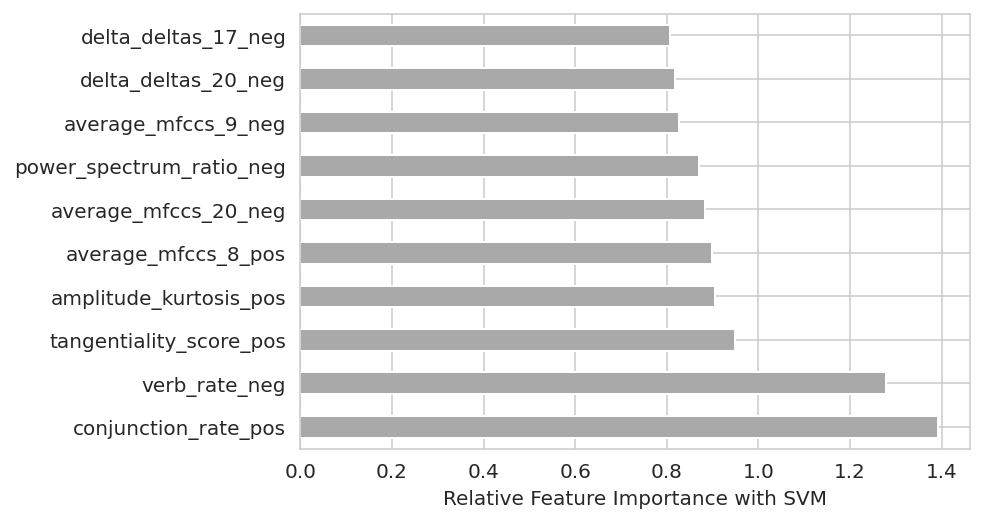

In [43]:
pd.Series(abs(clf.coef_[0]), index=df_full.columns).nlargest(10).plot(kind='barh', color='darkgrey')
plt.xlabel('Relative Feature Importance with SVM');

### Optimizing Hyper-parameters (SVM)

Next, we will optimizy the classifier hyper-parameters with cross-validation, which is done using the GridSearchCV.

In [44]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1, 'kernel': 'linear'}

Grid scores on development set:

0.267 (+/-0.027) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.267 (+/-0.027) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.267 (+/-0.027) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.267 (+/-0.027) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.574 (+/-0.163) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.267 (+/-0.027) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.586 (+/-0.152) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.574 (+/-0.163) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.625 (+/-0.086) for {'C': 1, 'kernel': 'linear'}
0.572 (+/-0.204) for {'C': 10, 'kernel': 'linear'}
0.572 (+/-0.204) for {'C': 100, 'kernel': 'linear'}
0.572 (+/-0.204) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full eva

Let's now train the model on the speech dataset only and see how it performs.

In [45]:
#Create a svm Classifier
clf_speech = SVC(C= 1, kernel='linear') # Linear Kernel

# start time
start = time.time()

#Train the model using the training sets
clf_speech.fit(X_train_speech, y_train_speech)

# check training time
print("Train time: {0}".format(time.time() - start))

#Predict the response for test dataset
y_pred_speech = clf_speech.predict(X_test_speech)

Train time: 0.003124237060546875


As we can see, we obtained lower accuracy score when training the model on the speech dataset only. It might be due to the fact that demographic variables have more weight in predicting.

In [46]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",accuracy_score(y_test_speech, y_pred_speech))

Accuracy: 0.625


In [47]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", precision_score(y_test_speech, y_pred_speech))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", recall_score(y_test_speech, y_pred_speech))

Precision: 0.6153846153846154
Recall: 0.6666666666666666


### 2. XGBoost Classifier

Next, we will use XGBoost to classify whether participant is depressed or not. XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost has become one of the most used tools in machine learning. It consist of an ensemble of decision trees, where each new tree depends on the evaluation of the previous one. This sequential way of adding classifiers its called boosting, but unlike traditional boosting, with XGBoost is possible to run it in parallel, since in the construction of the trees each branch is trained independently.

https://medium.com/sfu-cspmp/xgboost-a-deep-dive-into-boosting-f06c9c41349

https://medium.com/@juniormiranda_23768/ensemble-methods-tuning-a-xgboost-model-with-scikit-learn-54ff669f988a

https://towardsdatascience.com/a-beginners-guide-to-xgboost-87f5d4c30ed7

In [48]:
# instantiate xgboost with the most optimal parameters
xgb_clf = xgb.XGBClassifier(
    objective ='binary:logistic',
    colsample_bytree = 0.7,
    gamma = 0.0, 
    learning_rate = 0.2,
    max_depth = 4,
    n_estimators = 150
    )

# start time
start = time.time()

# train the model
xgb_clf.fit(X_train, y_train)

# check training time
print("Train time: {0}".format(time.time() - start))

_model_XGboost_dur = time.time() - start

[13:47:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train time: 0.10879254341125488


In [49]:
# predict the values
y_pred_train = xgb_clf.predict(X_train)
y_pred_test = xgb_clf.predict(X_test)

print("Precision = {}".format(precision_score(y_test, y_pred_test, average='macro')))
print("Recall = {}".format(recall_score(y_test, y_pred_test, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, y_pred_test)))

# get the accuracy score for the plot
_model_XGboost_acc = accuracy_score(y_test, y_pred_test)

Precision = 0.5419580419580419
Recall = 0.5416666666666667
Accuracy = 0.5416666666666666


Let's plot the the feature importance for the XGBoost Classifier. We can see that `total_dep_distance_pos` and `adjective_rate_neg` are the most important predictors in the model.

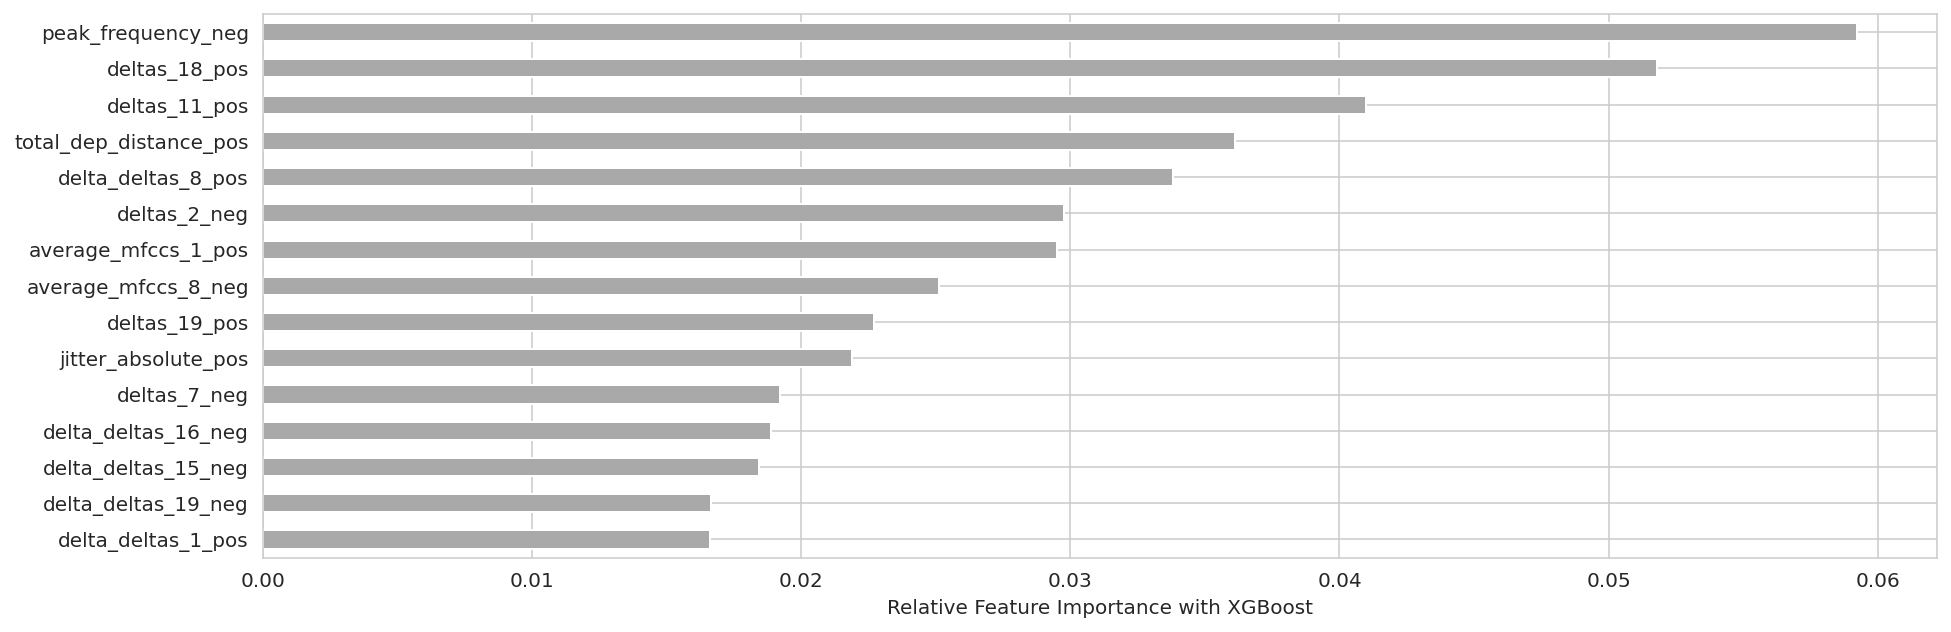

In [50]:
features_importance = pd.Series(xgb_clf.feature_importances_, index=df_full.columns)
features_importance.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(15,5))
plt.xlabel('Relative Feature Importance with XGBoost');

As every machine learning algorithm, XGBoost also has hyperparameters to tune. In order to do this in a simple and efficient way, we’ll combine it with scikit-learn GridSearchCV.

In [51]:
# xgb_clf = xgb.XGBClassifier(objective='binary:logistic',)

# parameters = {
#      "n_estimators"     : [ 100, 150, 200 ],
#      "max_depth"        : [ 3, 4, 5, 6, 7 ],
#      "learning_rate"    : [ 0.01, 0.1, 0.2 ],
#      "gamma"            : [ 0.0, 0.1, 0.2 ],
#      "colsample_bytree" : [ 0.4, 0.5 , 0.7 ]
#      }

# grid = GridSearchCV(xgb_clf,
#                     parameters, n_jobs=4,
#                     scoring="accuracy",
#                     cv=3)

# grid.fit(X_train, y_train)

In [52]:
# print(grid.best_params_)

### 3. K-NN classifier ###


#### Creating the model and training it ####

First we create the model and set the # of neighbors to `3`. We chose 3 since it seems to be a good starting value since it is the next odd number after 1 (to ensure it is always clear into which category it is classified), and 1 is too much of a small number to really say if the newly added data should belong to that class. For recap, this means that if at least 2 out of the 3 nearest neighbors of the point we want to predict are depressed, our new data point will be categorized as 'depressed'. We will see in a further section if K=3 is a 'good' value for K and how to better select K. Also, we use `euclidian distance` as distance evaluation metric. The euclidian distance (in 2 dimensional space) is defined as follows:
<img src="image-20210428-172209.png" width="400"/> Source: https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Euclidean_distance_2d.svg/1200px-Euclidean_distance_2d.svg.png

In [53]:
# creating the KNN model with K=3
model = KNeighborsClassifier(n_neighbors=3, metric = "euclidean")

start = time.time()
# fitting the model with training data
model.fit(X_train, y_train)

print("Train time: {0}".format(time.time() - start))
_model_KNN_dur = time.time() - start

Train time: 0.0014388561248779297


Once the model is trained, we can use it to predict some test values. We use the first 5 values of our test set as example.

In [54]:
# show first 5 model predictions on the test data
model.predict(X_test)[0:5]

array([1., 0., 1., 1., 1.])

And we can also calculate the `accuracy` of our model on our test set:

In [55]:
# check accuracy of our model on the test data
print(model.score(X_test, y_test))

# need a copy for final results summary
_model_KNN_acc = model.score(X_test, y_test)

0.5833333333333334


As you may notice, we have an accuracy score of `.58`, which is not that great considering that only every second entry is correctly classified, but it's a start.

#### Training with k-Fold Cross-Validation ####

We can improve the accuracy of our model by using a technique called `k-fold cross-validation`, which is when the dataset is randomly split up into K groups or folds. 1 fold is then used as test set and the remaining 4 are used asd training set. This then repeated K times until every fold has been used exactly once as test set. Example: 5-fold cross-validation
<img src="https://miro.medium.com/max/2736/1*rgba1BIOUys7wQcXcL4U5A.png" width="600">
Source: https://miro.medium.com/max/2736/1*rgba1BIOUys7wQcXcL4U5A.png

In [56]:
# create a new KNN model
model_cv = KNeighborsClassifier(n_neighbors=3)

start = time.time()
# train model with cv of 5 
cv_scores = cross_val_score(model_cv, X_train, y_train, cv=5)

print("Train time: {0}".format(time.time() - start))
_model_Kfold_cross_val_dur = time.time() - start

# print each cv score (accuracy) and average them
i=0
for cv_score in cv_scores:
    print("Iteration {} cv_score:".format(i+1), cv_scores[i] )
    i += 1


print("cv_scores mean: {}".format(np.mean(cv_scores)))

# get the accuracy score for the plot
_model_Kfold_cross_val = np.mean(cv_scores)

Train time: 0.026004314422607422
Iteration 1 cv_score: 0.7777777777777778
Iteration 2 cv_score: 0.3888888888888889
Iteration 3 cv_score: 0.5
Iteration 4 cv_score: 0.4444444444444444
Iteration 5 cv_score: 0.5555555555555556
cv_scores mean: 0.5333333333333334


The mean accuracy scorce using 5-fold crossfold validation is actually worse than our previous accuracy score, so we need a new approach.

#### Hypertuning model parameters using GridSearchCV ####

Hypertuning parameters is when you try to find the best parameters for your model i.e. find the ones that give your model the best accuracy. Initially we set `K = 3`. But what if there's another value of K that performs better? `GridSearchCV` allows us to do just that. Our new model using grid search will take in a new k-NN classifier, our param_grid and a `cross-validation` value of 5 in order to find the optimal value for ‘n_neighbors’.

In [57]:
#create new a knn model
model_grid = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {"n_neighbors": np.arange(1, 25)}

#use gridsearch to test all values for n_neighbors
model_grid = GridSearchCV(model_grid, param_grid, cv=5)

#start of timer for training
start = time.time()

#fit model to data
model_grid.fit(X_train, y_train)

# check training time
print("Train time: {0}".format(time.time() - start))
_model_KNN_hyper_tuned_dur = time.time() - start

#check top performing n_neighbors value
print(model_grid.best_params_)

#check mean score for the top performing value of n_neighbors
print(model_grid.best_score_)

# need the score for final summary
_model_KNN_hyper_tuned = model_grid.best_score_

y_true, y_pred = y_test, model_grid.predict(X_test)
print(classification_report(y_true, y_pred))


Train time: 0.5818097591400146
{'n_neighbors': 13}
0.5666666666666667
              precision    recall  f1-score   support

         0.0       0.57      0.33      0.42        12
         1.0       0.53      0.75      0.62        12

    accuracy                           0.54        24
   macro avg       0.55      0.54      0.52        24
weighted avg       0.55      0.54      0.52        24



The best K value is 24 and the accuracy for that particular K is `0.6`, which is not too bad considering we started with an accuracy score of .51, but there certainly exist better models for our task! Let's see if `removing non-speech features` will improve our accuracy score.

In [58]:
#create new a knn model
model_grid = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {"n_neighbors": np.arange(1, 25)}

#use gridsearch to test all values for n_neighbors
model_grid = GridSearchCV(model_grid, param_grid, cv=5)

#start of timer for training
start = time.time()

#fit model to data
model_grid.fit(X_train_speech, y_train_speech)

#end of timer for training
print("Train time: {0}".format(time.time() - start))

#check top performing n_neighbors value
print(model_grid.best_params_)

#check mean score for the top performing value of n_neighbors
print(model_grid.best_score_)

y_true, y_pred = y_test, model_grid.predict(X_test_speech)
print(classification_report(y_true, y_pred))



Train time: 0.6121957302093506
{'n_neighbors': 8}
0.5666666666666667
              precision    recall  f1-score   support

         0.0       0.70      0.58      0.64        12
         1.0       0.64      0.75      0.69        12

    accuracy                           0.67        24
   macro avg       0.67      0.67      0.66        24
weighted avg       0.67      0.67      0.66        24



There is no improvement from removing non-speech features in a KNN model.

### 4. Deep-learning with Keras (The Sequential Model) ###

Keras is an open-source library for deep-learning which acts as an interface for the Tensorflow library. We try and implement a sequential model to see if it gives better results than our other approaches. We use a sequential model. A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor. Wikipedia defines a tensor as follows: "In mathematics, a tensor is an algebraic object that describes a (multilinear) relationship between sets of algebraic objects related to a vector space."

First of all, we create the model, define the input dimension and add a set of layers. A short summary of the model is also displayed.

In [59]:
# same seed 
#np.random.seed(1337)

# defining the model
model = keras.models.Sequential()

# define early stopping callback
es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=15)

# define the input shape
input_dim = X_train.shape[1]


# add network layers
model.add(keras.Input(shape=(input_dim,)))
model.add(keras.layers.Dense(412, activation='relu'))
model.add(keras.layers.Dense(824, activation='relu'))
model.add(keras.layers.Dense(1648, activation='relu'))
model.add(keras.layers.Dropout(0.15))
model.add(keras.layers.Dense(2, activation='softmax'))


# show the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 412)               85284     
_________________________________________________________________
dense_1 (Dense)              (None, 824)               340312    
_________________________________________________________________
dense_2 (Dense)              (None, 1648)              1359600   
_________________________________________________________________
dropout (Dropout)            (None, 1648)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 3298      
Total params: 1,788,494
Trainable params: 1,788,494
Non-trainable params: 0
_________________________________________________________________


Next, we compile and train the model. Compiling defines the loss function, the optimizer and the metrics. We use 100 epochs as a baseline.

In [60]:
# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#start of timer for training
start = time.time()

# fit the model
history = model.fit(X_train, y_train, epochs = 100, callbacks=[es], validation_split=0.2)

# check training time
print("Train time: {0}".format(time.time() - start))
_model_keras_dl_dur = time.time() - start

Epoch 1/100
3/3 [==============================] - 2s 635ms/step - loss: 0.7071 - accuracy: 0.4696 - val_loss: 0.8206 - val_accuracy: 0.2778
Epoch 2/100
3/3 [==============================] - 0s 31ms/step - loss: 0.5867 - accuracy: 0.7135 - val_loss: 0.6123 - val_accuracy: 0.7222
Epoch 3/100
3/3 [==============================] - 0s 35ms/step - loss: 0.6342 - accuracy: 0.5820 - val_loss: 1.1596 - val_accuracy: 0.2778
Epoch 4/100
3/3 [==============================] - 0s 31ms/step - loss: 0.6247 - accuracy: 0.6753 - val_loss: 0.6481 - val_accuracy: 0.7222
Epoch 5/100
3/3 [==============================] - 0s 32ms/step - loss: 0.6366 - accuracy: 0.5877 - val_loss: 0.7699 - val_accuracy: 0.5000
Epoch 6/100
3/3 [==============================] - 0s 32ms/step - loss: 0.4777 - accuracy: 0.8090 - val_loss: 0.6401 - val_accuracy: 0.6111
Epoch 7/100
3/3 [==============================] - 0s 30ms/step - loss: 0.5094 - accuracy: 0.8268 - val_loss: 0.7477 - val_accuracy: 0.5556
Epoch 8/100
3/3 [==

We can now test the model using our testing sets.

In [61]:
# testing
print(model.evaluate(X_test, y_test))\

# get the accuracy score for the plot
_model_keras_dl_acc = model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 89ms/step - loss: 2.1052 - accuracy: 0.5833
[2.1052064895629883, 0.5833333134651184]
1/1 [==============================] - 0s 15ms/step - loss: 2.1052 - accuracy: 0.5833


The end result is slightly better than the KNN classifier results but still not great. We can achieve similar if not better results with the VSM model, hence we need to change our approach a bit. In the next week(s) we will try to find out why the deep learning approach is doing so poorly compared to regular machine learning approaches and adapt our features.

Finally, in order to visualize and summarize both the accuracy and loss history of the model accross the epochs we created some graphs:

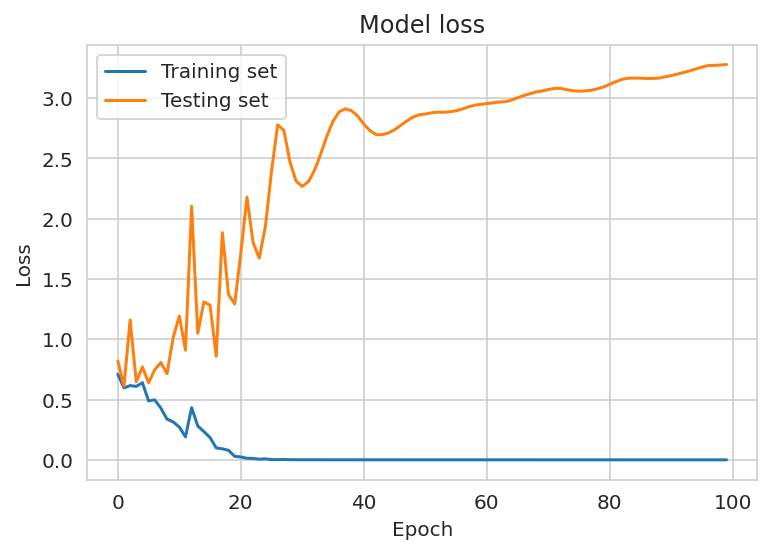

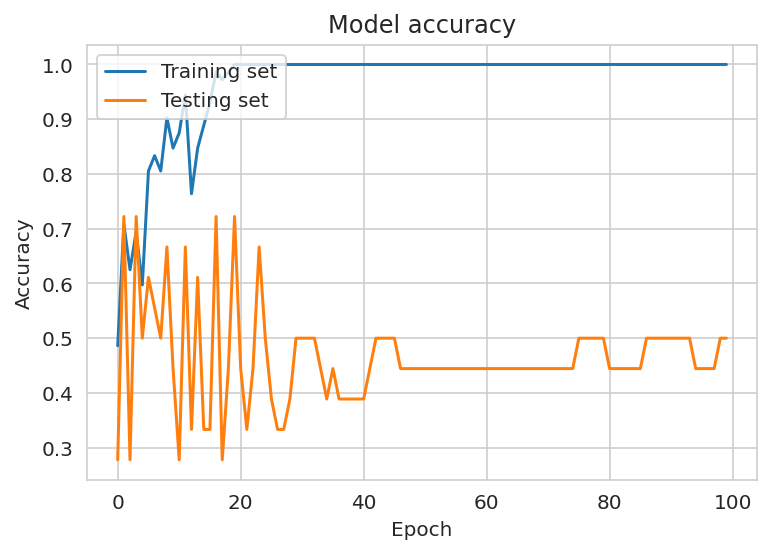

In [62]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Testing set'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Testing set'], loc='upper left')
plt.show()

`Accuracy` is a method for measuring a classification model’s performance. It is typically expressed as a percentage.  Accuracy is the count of predictions where the predicted value is equal to the true value.

`Loss` can be seen as a distance between the truth values and the values predicted by the model. The greater the loss is, the "larger" the error that was made. If the model's prediction is perfect, the loss is zero; otherwise, the loss is greater.

### 5. Bayesian Network Model ###

In [63]:
_data = boghos_copy_df
_data.head()
# g = sns.FacetGrid(_data, col="age", row="gender")
# g.map(sns.scatterplot, "education", "dep_scale")
# sns.FacetGrid(_data, col="age", row="gender").map(sns.scatterplot, "education", "dep_scale")

id  age  gender  education  dep_scale  speech_ratio_neg  \
0  2274   22  female         14         16          0.907169   
1  2275   21  female         13         15          0.883506   
2  2276   21  female         13         23          0.863110   
3  2282   23    male         16         12          0.842673   
4  2283   28    male         17         15          0.819487   

   speech_ratio_pos  harmonics_to_noise_ratio_neg  \
0          0.895368                     12.267561   
1          0.879200                     14.369169   
2          0.841594                     13.401637   
3          0.836735                      4.736998   
4          0.625387                      5.536166   

   harmonics_to_noise_ratio_pos  sound_to_noise_ratio_neg  ...  \
0                     11.590832                  0.000002  ...   
1                      6.955338                  0.000019  ...   
2                     12.859636                  0.000020  ...   
3                      5.777533                  0.000067  ...   
4                      5.677916                  0.000200  ...   

   mean_cluster_density_neg  mean_cluster_density_pos  \
0                  4.666667                 68.000000   
1                 89.000000                  4.666667   
2                 76.000000                 49.000000   
3                  4.187500                  3.047619   
4                  2.600000                  2.800000   

   biggest_cluster_density_neg  biggest_cluster_density_pos  \
0                           28                           68   
1                           89                           15   
2                           76                           49   
3                           17                           13   
4                            9                            6   

   number_cluster_switches_neg  number_cluster_switches_pos  \
0                           38                            0   
1                            0                           33   
2                            0                            0   
3                           58                           59   
4                            6                            8   

   tangentiality_score_neg  tangentiality_score_pos  coherence_metric_neg  \
0                 0.603030                 0.183499              1.045455   
1                 0.708475                 0.329545              0.949153   
2                 0.557627                 0.531034              0.949153   
3                 0.650612                 0.404706              1.061225   
4                 0.933333                 0.711111              1.333333   

   coherence_metric_pos  
0              0.810811  
1              0.937500  
2              0.896552  
3              0.640000  
4              0.888889  

[5 rows x 215 columns]

### 6. Naive Bayes model

In [64]:
#Create a Gaussian Classifier
_model = GaussianNB()

start = time.time()
# Train the model using the training sets
_history = _model.fit(X_train,y_train)

print("Train time: {0}".format(time.time() - start))
_model_NBayesian_dur = time.time() - start

#Predict Output
predicted= _model.predict(X_test) # 0:Overcast, 2:Mild
print("Predicted Value:", predicted)
print("Accuracy = ",_model.score(X_test, y_test, sample_weight=None))

# get the accuracy score for the plot
_model_NBayesian_acc = _model.score(X_test, y_test, sample_weight=None)

Train time: 0.002515077590942383
Predicted Value: [1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1.]
Accuracy =  0.5833333333333334


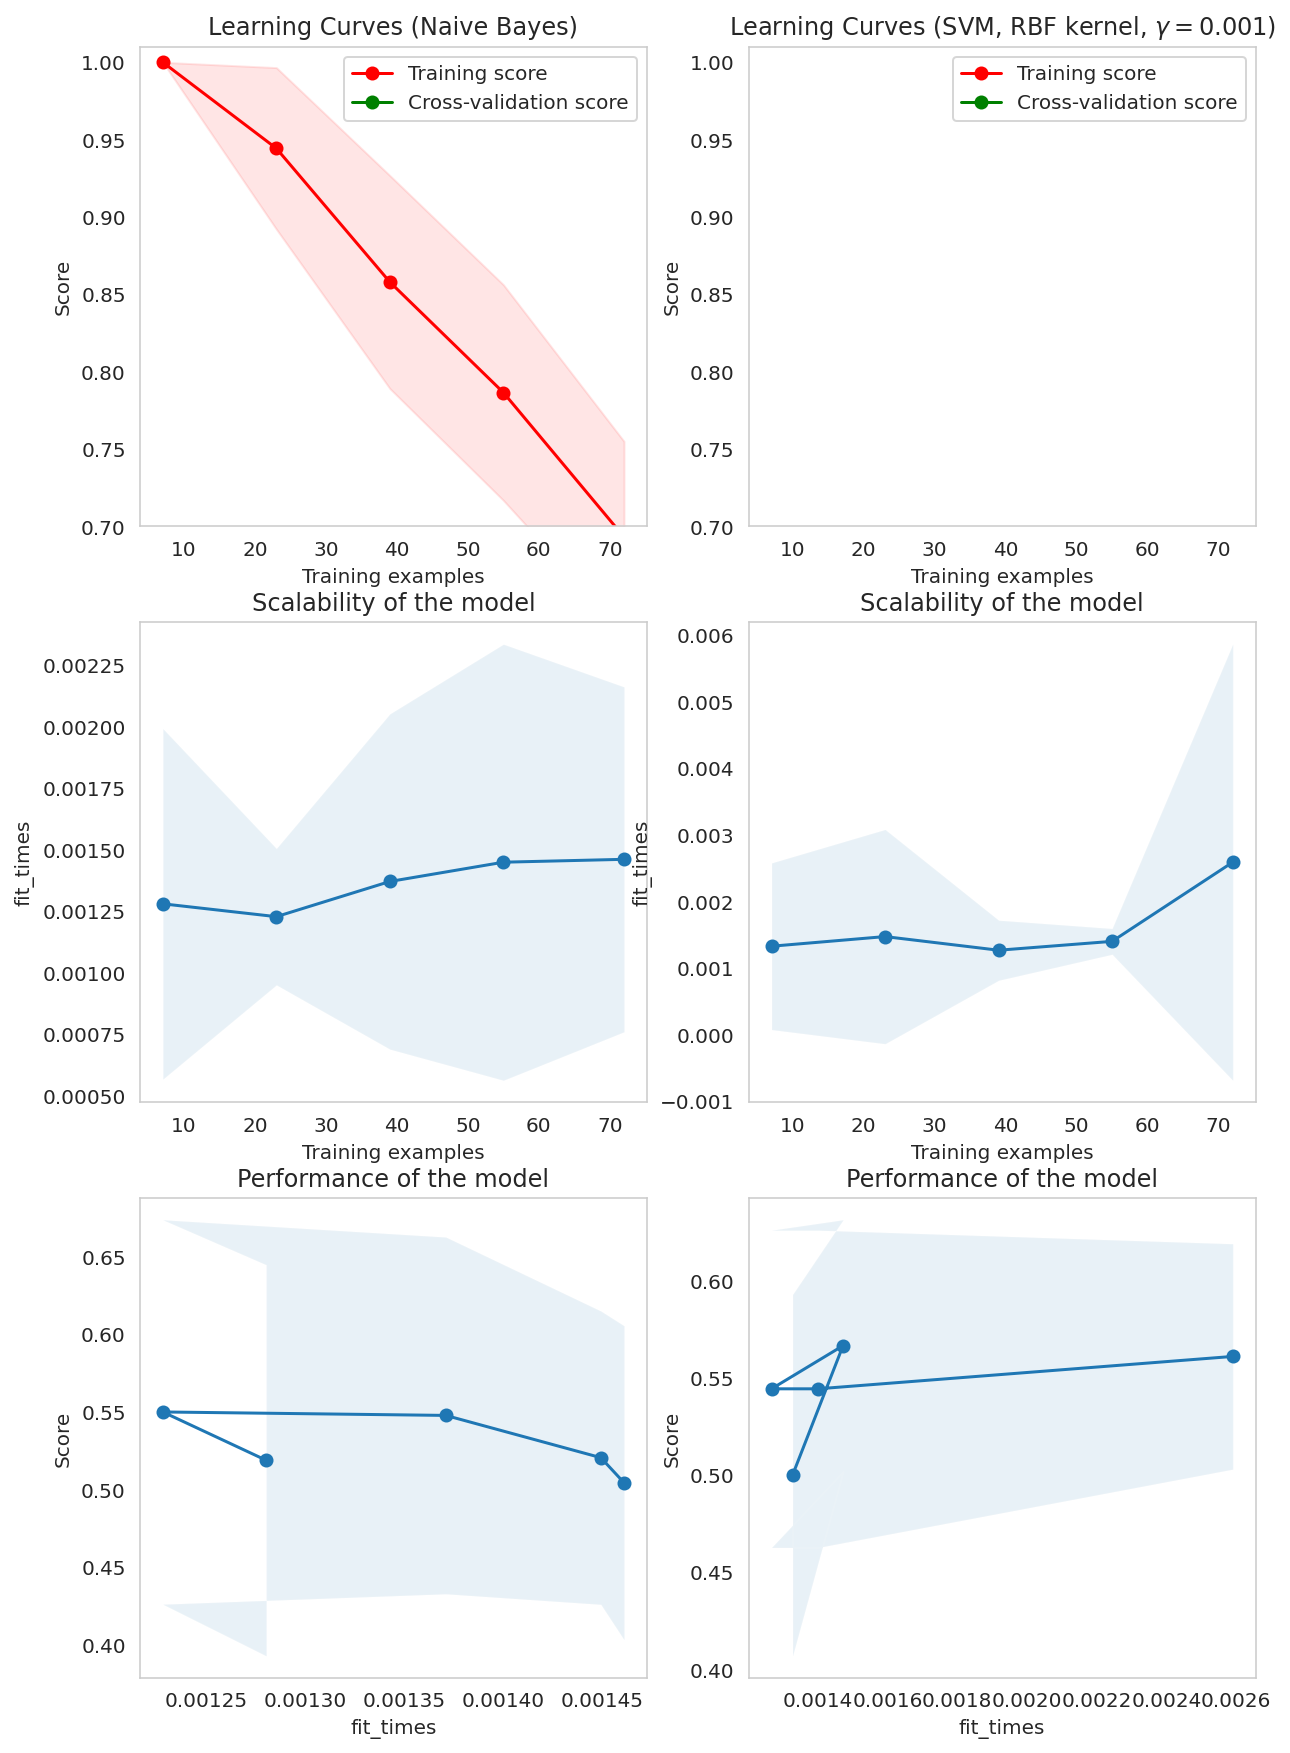

In [65]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))


title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X_train, y_train, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X_train, y_train, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

### 7. Decision tree classifier

In [66]:
Model = DecisionTreeClassifier()

start = time.time()

Model.fit(X_train, y_train)

print("Train time: {0}".format(time.time() - start))
_model_DT_dur = time.time() - start

y_pred = Model.predict(X_test)# Summary of the predictions made by the classifier
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
# Accuracy score
print('Accuracy is',accuracy_score(y_pred,y_test))

# get the accuracy score for the plot
_model_DT_acc = accuracy_score(y_pred,y_test)

Train time: 0.006861448287963867
              precision    recall  f1-score   support

         0.0       0.53      0.67      0.59        12
         1.0       0.56      0.42      0.48        12

    accuracy                           0.54        24
   macro avg       0.54      0.54      0.53        24
weighted avg       0.54      0.54      0.53        24

[[8 4]
 [7 5]]
Accuracy is 0.5416666666666666


## Results summary

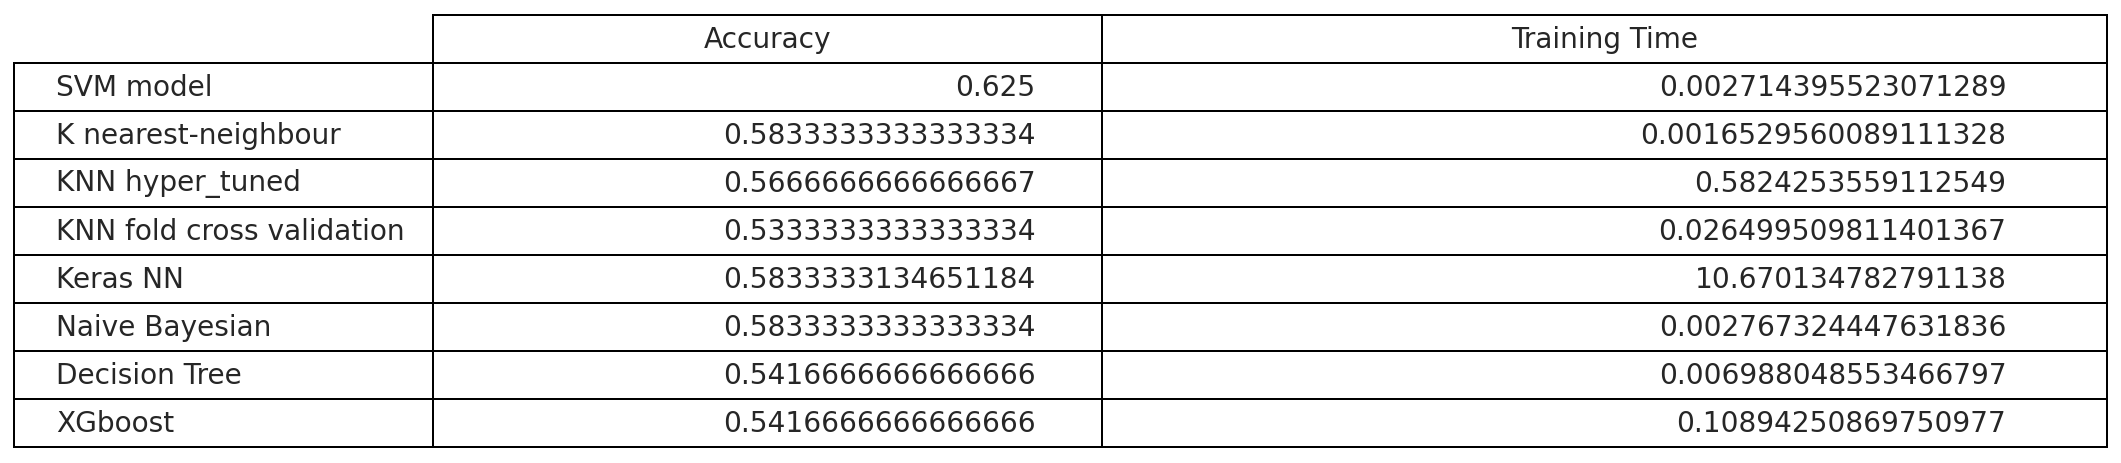

In [67]:
# _model_KNN_acc
# _model_KNN_hyper_tuned
# _model_Kfold_cross_val
# _model_keras_dl
# _model_NBayesian_acc
# _model_DT_acc
# _model_SVM_acc
# _model_XGboost_acc


# _model_XGboost_dur
# _model_KNN_dur
# _model_Kfold_cross_val_dur
# _model_keras_dl_dur
# _model_NBayesian_dur
# _model_DT_dur
# _model_SVM_dur
# _model_KNN_hyper_tuned_dur

# _models_acc = [_model_SVM_acc, _model_KNN_acc, _model_KNN_hyper_tuned, _model_Kfold_cross_val, _model_keras_dl, _model_NBayesian_acc, _model_DT_acc, _model_XGboost_acc]
# _models_dur = [_model_XGboost_dur, _model_KNN_dur, _model_Kfold_cross_val_dur, _model_keras_dl_dur, _model_NBayesian_dur, _model_DT_dur, _model_SVM_dur, _model_KNN_hyper_tuned_dur]

final_summary = [[_model_SVM_acc, _model_SVM_dur], 
                 [_model_KNN_acc, _model_KNN_dur], [_model_KNN_hyper_tuned, _model_KNN_hyper_tuned_dur],
                 [_model_Kfold_cross_val, _model_Kfold_cross_val_dur], [_model_keras_dl_acc, _model_keras_dl_dur],
                 [_model_NBayesian_acc, _model_NBayesian_dur], [_model_DT_acc, _model_DT_dur],
                 [_model_XGboost_acc, _model_XGboost_dur]]



fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

columns = ["Accuracy", "Training Time"]
rows = ["SVM model", "K nearest-neighbour", "KNN hyper_tuned", "KNN fold cross validation", "Keras NN", "Naive Bayesian", "Decision Tree", "XGboost"] 

new_df = pd.DataFrame(final_summary, columns=columns)

table = ax.table(cellText=new_df.values, colLabels=new_df.columns, rowLabels=rows, colWidths = [0.5, 0.75],loc='center')
table.scale(2, 2)
table.set_fontsize(14)
# table.set_text_props(family='sans-serif')
fig.tight_layout()

plt.show()

# Gender Difference

Let's see how our baseline SVM model predicts the depression between male and female based on speech features only. Let's split the dataset on training and testing sets. The first dataset contains **only female observations**. The second dataset contains  **only male observations**. 

We use `test_size = 0.2`. We also use `random_state` to select records randomly.

In [68]:
# split our data in female and male
dfs = [rows for _, rows in df.groupby('gender')]

# create dataframe for female
df_speech_female = dfs[0]
# create dataframe for male
df_speech_male = dfs[1]

df_speech_male = df_speech_male.drop(columns = demographic_clinical_feats)
df_speech_female = df_speech_female.drop(columns = demographic_clinical_feats)

df_speech_male_target = df_speech_male.depressed
df_speech_female_target = df_speech_female.depressed

df_speech_male = df_speech_male.drop(['depressed'], axis = 1)
df_speech_female = df_speech_female.drop(['depressed'], axis = 1)

X_train_speech_male, X_test_speech_male, y_train_speech_male, y_test_speech_male = train_test_split(df_speech_male, df_speech_male_target, test_size=0.2, random_state=10)
X_train_speech_female, X_test_speech_female, y_train_speech_female, y_test_speech_female = train_test_split(df_speech_female, df_speech_female_target, test_size=0.2, random_state=10)

# summarize the shape of the training datasets
print(X_train_speech_male.shape, y_train_speech_male.shape)
print(X_train_speech_female.shape, y_train_speech_female.shape)

# summarize the shape of the test datasets
print(X_test_speech_male.shape, y_test_speech_male.shape)
print(X_test_speech_female.shape, y_test_speech_female.shape)




(21, 210) (21,)
(73, 210) (73,)
(6, 210) (6,)
(19, 210) (19,)


## Data Modeling

After splitting the dataset, we only have **21** male participants and **73** female participants.

For predicting the depression for each of the genders, we will not detect outliers and remove highly correlated features, as we don't have that many observations for each of the participants.

### Predicting Depression for Males

First, let's try to fit the baseline SVM model with the male dataset.

In [69]:
#Create a svm Classifier
clf_speech_male = SVC(kernel='linear') # Linear Kernel

# start time
start = time.time()

#Train the model using the training sets
clf_speech_male.fit(X_train_speech_male, y_train_speech_male)

# check training time
print("Train time: {0}".format(time.time() - start))

_model_SVM_dur = time.time() - start

#Predict the response for test dataset
y_pred_speech_male = clf_speech_male.predict(X_test_speech_male)

Train time: 0.00503230094909668


As we can see, the accuracy for the male participants is very low. This is most likely due to the fact that we have very few observations of the male subjects.

In [70]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:", accuracy_score(y_test_speech_male, y_pred_speech_male))

Accuracy: 0.3333333333333333


In [71]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", precision_score(y_test_speech_male, y_pred_speech_male))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", recall_score(y_test_speech_male, y_pred_speech_male))

Precision: 0.5
Recall: 0.5


As we can see `average_mfccs_9_neg`, and `adjective_rate_pos` are the most contributing features for the male participants.

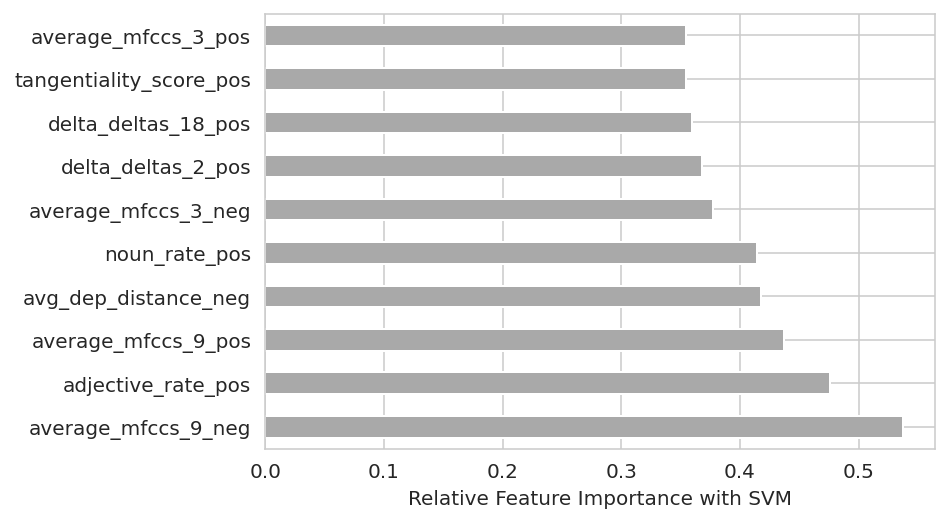

In [72]:
pd.Series(abs(clf_speech_male.coef_[0]), index=df_speech_male.columns).nlargest(10).plot(kind='barh', color='darkgrey')
plt.xlabel('Relative Feature Importance with SVM');

### Predicting Depression for Females

In [73]:
#Create a svm Classifier
clf_speech_female = SVC(kernel='linear') # Linear Kernel

# start time
start = time.time()

#Train the model using the training sets
clf_speech_female.fit(X_train_speech_female, y_train_speech_female)

# check training time
print("Train time: {0}".format(time.time() - start))

_model_SVM_dur = time.time() - start

#Predict the response for test dataset
y_pred_speech_female = clf_speech_female.predict(X_test_speech_female)

Train time: 0.008022069931030273


In [74]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:", accuracy_score(y_test_speech_female, y_pred_speech_female))

Accuracy: 0.5789473684210527


In [75]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:", precision_score(y_test_speech_female, y_pred_speech_female))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:", recall_score(y_test_speech_female, y_pred_speech_female))

Precision: 0.6666666666666666
Recall: 0.5454545454545454


As we can see `verb_rate_neg`, and `conjuction_rate_pos` are the most contributing features for the female participants.

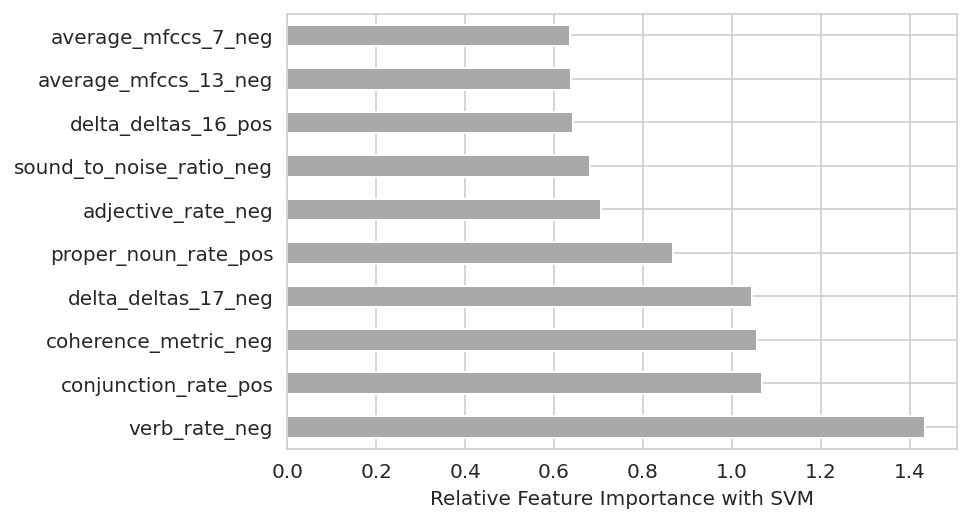

In [76]:
pd.Series(abs(clf_speech_female.coef_[0]), index=df_speech_female.columns).nlargest(10).plot(kind='barh', color='darkgrey')
plt.xlabel('Relative Feature Importance with SVM');

Next, let's try to take the ten most important features for both genders and see if the accuracy would improve.

In [77]:
df_female_coef = pd.Series(abs(clf_speech_female.coef_[0]), index=df_speech_female.columns).nlargest(10)

df_female_features = pd.DataFrame(df_speech_female, columns=df_female_coef.index)
df_female_coef

verb_rate_neg               1.434983
conjunction_rate_pos        1.068373
coherence_metric_neg        1.056550
delta_deltas_17_neg         1.045941
proper_noun_rate_pos        0.866575
adjective_rate_neg          0.704899
sound_to_noise_ratio_neg    0.680313
delta_deltas_16_pos         0.642264
average_mfccs_13_neg        0.639116
average_mfccs_7_neg         0.636447
dtype: float64

In [78]:
df_male_coef = pd.Series(abs(clf_speech_male.coef_[0]), index=df_speech_male.columns).nlargest(10)

df_male_features = pd.DataFrame(df_speech_male, columns=df_male_coef.index)
df_male_features

average_mfccs_9_neg  adjective_rate_pos  average_mfccs_9_pos  \
3               0.591627            0.589286             0.462328   
4               0.755001            0.448980             0.691673   
5               0.926031            0.613240             0.821879   
6               0.816139            0.333755             0.727079   
8               0.864073            1.000000             0.807659   
15              0.932628            0.474394             1.000000   
16              0.833480            0.443697             0.697305   
29              0.686803            0.182195             0.613786   
31              0.970200            0.199546             0.969704   
34              0.546953            0.308411             0.511204   
41              0.717322            0.283140             0.657792   
51              0.676262            0.292978             0.356273   
53              0.315511            0.274785             0.426967   
55              0.748951            0.230971             0.785447   
59              0.236965            0.386813             0.274411   
68              0.388100            0.372881             0.391865   
70              1.000000            0.169884             0.892394   
71              0.600041            0.000000             0.481992   
72              0.774650            0.378657             0.744409   
74              0.789152            0.414443             0.720865   
75              0.525827            0.423756             0.437902   
93              0.564216            0.785714             0.759408   
97              0.642113            0.237197             0.620490   
98              0.716636            0.248120             0.629263   
102             0.076650            0.785714             0.489466   
114             0.282301            0.523810             0.262597   
116             0.309020            0.592992             0.251397   

     avg_dep_distance_neg  noun_rate_pos  average_mfccs_3_neg  \
3                0.687105       0.794635             0.554996   
4                0.225629       0.205620             0.352026   
5                0.777542       0.501883             0.333677   
6                0.719124       0.305700             0.786211   
8                0.642302       0.586397             0.617564   
15               0.844532       0.376850             0.472520   
16               0.680700       0.683607             0.785187   
29               0.671928       0.381660             0.313156   
31               0.582156       0.810633             0.334748   
34               0.462349       0.362201             0.939417   
41               0.756261       0.209393             0.477361   
51               0.675197       0.432795             0.951625   
53               0.483713       0.555810             0.759297   
55               0.771057       0.448578             0.358065   
59               0.660316       0.147624             0.715247   
68               0.584385       0.482490             0.316104   
70               0.360045       0.209393             0.534604   
71               0.330328       0.833902             0.219209   
72               0.426215       0.705218             0.306457   
74               0.735116       0.560036             0.416327   
75               0.530611       0.643300             0.500995   
93               0.225629       0.519761             0.810412   
97               0.535336       0.505931             0.681058   
98               0.822072       0.249710             0.728619   
102              0.158022       0.519761             0.136512   
114              0.225353       0.519761             0.684111   
116              0.230202       0.118688             0.747358   

     delta_deltas_2_pos  delta_deltas_18_pos  tangentiality_score_pos  \
3              0.738803             0.265412                 0.369899   
4              0.000000             0.540266                 0.754339   
5              0.848105         

In [79]:
X_train_male_feat, X_test_male_feat, y_train_male_feat, y_test_male_feat = train_test_split(df_male_features, df_speech_male_target, test_size=0.2, random_state=10)
X_train_female_feat, X_test_female_feat, y_train_female_feat, y_test_female_feat = train_test_split(df_female_features, df_speech_female_target, test_size=0.2, random_state=10)

### Feature Importance for Genders

As we can see, the accuracy for the male participants is the same when taking only the ten most contirbuting features. However, the accuracy for the female participants has improved.

In [80]:
#Create a svm Classifier
clf_male_feat = SVC(C= 1, kernel='linear') # Linear Kernel

# start time
start = time.time()

#Train the model using the training sets
clf_male_feat.fit(X_train_male_feat, y_train_male_feat)

# check training time
print("Train time: {0}".format(time.time() - start))

#Predict the response for test dataset
y_pred_male_feat = clf_male_feat.predict(X_test_male_feat)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",accuracy_score(y_test_male_feat, y_pred_male_feat))

# model report after testing
print(classification_report(y_test_male_feat, y_pred_male_feat))

Train time: 0.003715038299560547
Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.33      1.00      0.50         2
         1.0       0.00      0.00      0.00         4

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6



In [81]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import time

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

score = 'precision'

clf_female_feat = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
)

# start time
start = time.time()

#Train the model using the training sets
clf_female_feat.fit(X_train_female_feat, y_train_female_feat)

# check training time
print("Train time: {0}".format(time.time() - start))

#Create a svm Classifier
clf_female_feat = SVC(C= 1, kernel='linear') # Linear Kernel

# fit it
clf_female_feat.fit(X_train_female_feat, y_train_female_feat)

#Predict the response for test dataset
y_pred_female_feat = clf_female_feat.predict(X_test_female_feat)

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",accuracy_score(y_test_female_feat, y_pred_female_feat))

# model report after testing
print(classification_report(y_test_female_feat, y_pred_female_feat))

Train time: 0.38043212890625
Accuracy: 0.6842105263157895
              precision    recall  f1-score   support

         0.0       0.62      0.62      0.62         8
         1.0       0.73      0.73      0.73        11

    accuracy                           0.68        19
   macro avg       0.68      0.68      0.68        19
weighted avg       0.68      0.68      0.68        19



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8e5d5160-5efe-47fd-989f-1067d25199ae' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>